In [1]:
import servo
import analyse
import plot

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
speed_3_data = pd.DataFrame({
    "times": [1.85449, 1.92676, 1.88867, 1.90918, 1.88672, 1.93359, 1.92383, 1.84668, 1.87012, 1.96777, 1.92969, 1.94433, 1.85351, 1.87109, 1.93652, 2.00976, 1.74121, 1.94922, 1.92285, 1.92383, 1.95215, 1.88086, 1.91113, 1.88086, 1.93164, 1.87695, 1.80859, 1.93164, 1.90625, 2.00683],    
})
speed_4_data = pd.DataFrame({
    "times": [1.4082, 1.36133, 1.35059, 1.37695, 1.41113, 1.3584, 1.37305, 1.39062, 1.39062, 1.36426, 1.38574, 1.41797, 1.3584, 1.44141, 1.30762, 1.38281, 1.31738, 1.47558, 1.36035, 1.39844, 1.43652, 1.34668, 1.36816, 1.37695, 1.39258, 1.44043, 1.37402, 1.38965, 1.41992, 1.27148, 1.46484, 1.37207, 1.32519, 1.44043, 1.39941],
})

files = np.array([ [f"Data/{p}/{n}.csv" for n in range(1,4)] for p in [ f"p{N}" for N in range(0,6)] ]).flatten()

velocity_3, velocity_4 = list(map(lambda data: (data
              .pipe(analyse.get_std_of_times)
              .pipe(analyse.get_velocity, 200E-6)
              .pipe(analyse.get_velocity_std)
              .pipe(analyse.get_velocity_and_error)
             ), [speed_3_data, speed_4_data]))

def timestamps_to_displacement(timestamped_data, velocity):

    data = (timestamped_data
            .pipe(servo.reindex_timestamps_with_times)
            .pipe(servo.calculate_displacement, velocity)
            #.pipe(servo.get_distances)
            #.pipe(servo.calculate_distances_error, velocity)
           )
    displacement_data = data.set_index("Displacement (m)")

    
    return displacement_data

def plot_pinhole_method(ax, dataset):
    xs = dataset.index.values*1E3 # in mm
    ys = dataset["Power (W)"].values*1E6 # in uW

    # PLOT GAUSS #
    coeffs, coeff_errs = analyse.fit_gauss(xs, ys)
    fit_ys = analyse.G(xs, *coeffs)
    
    lower_bound, upper_bound = analyse.get_e_squared_range(xs, fit_ys)
    
    ax.set_xlabel("Displacement [mm]")
    
    ax.plot(xs, ys, marker='.', linestyle='', color="tab:blue", label="meas")
    ax.plot(xs, fit_ys,linestyle='--', linewidth=3, color="tab:red", label="gauss fit")
    plot.draw_dimension_lines(ax, upper_bound, lower_bound)
    ax.vlines(lower_bound, 0, max(ys), linestyle=':',  linewidth=2, color="black")
    ax.vlines(upper_bound, 0, max(ys), linestyle=':',  linewidth=2, color="black")

    return upper_bound - lower_bound
    


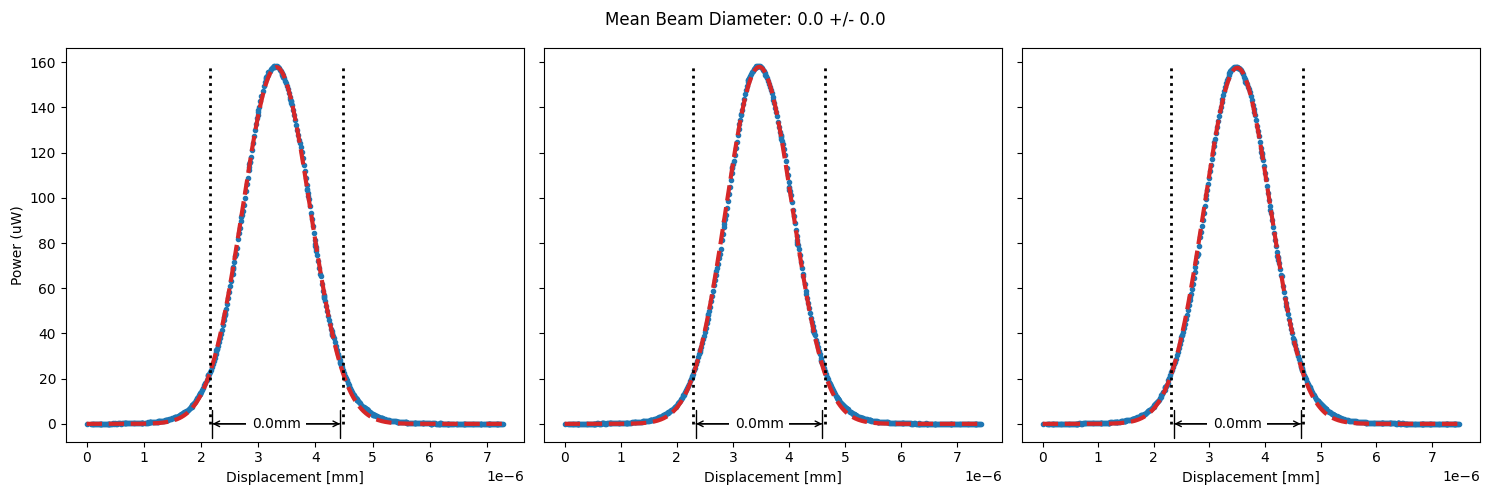

In [3]:
INITIAL_POSITION = 0.01065
ps = list(map(lambda p: (p*25*1E-3) + INITIAL_POSITION, [0, 6, 26, 31, 51, 57])) 

timestamped_data = map(servo.get_data, files)
displacement_data = map(
    lambda m: timestamps_to_displacement(m, velocity_4),
    timestamped_data
)
gauss_coeffs_and_errs = map(
    lambda dataset: [analyse.fit_gauss( dataset.index.values, dataset["Power (W)"].values )],
    displacement_data
)

fig, axes = plt.subplots(1,3,figsize=(15,5), sharey=True)
axes[0].set_ylabel("Power (uW)")
diameters = np.array([
    plot_pinhole_method(ax, data) for ax, data in zip(axes, [*displacement_data][:3])
])
mean_diam = diameters.mean()
mean_diam_err = diameters.std()/np.sqrt(len(diameters))
fig.suptitle(f"Mean Beam Diameter: {round(mean_diam, 3)} +/- {round(mean_diam_err, 3)}")
plt.tight_layout()


In [4]:
def plot_knife_edge_method(ax, dataset):
    xs = dataset.index.values*1E3 # in mm
    ys = dataset["Power (W)"].values*1E6 # in uW
    
    coeffs, coeff_errs = analyse.fit_erf(xs, ys)
    fit_ys = analyse.erf(xs, *coeffs)

    gauss_ys = analyse.G(xs, 2*coeffs[0], coeffs[1], coeffs[2]/np.sqrt(2))

    lower_bound, upper_bound = analyse.get_e_squared_range(xs, gauss_ys)

    ax.set_xlabel("Displacement [mm]")
    
    ax.plot(xs, ys, marker='.', linestyle='', color="tab:blue", label="meas")
    ax.plot(xs, fit_ys,linestyle='--', linewidth=3, color="tab:red", label="erf fit")
    ax.plot(xs, gauss_ys, linestyle='--', linewidth=3, color="tab:purple", label="gauss fit")
    
    plot.draw_dimension_lines(ax, upper_bound, lower_bound)
    ax.vlines(lower_bound, 0, max(ys), linestyle=':', linewidth=2, color="black")
    ax.vlines(upper_bound, 0, max(ys), linestyle=':',  linewidth=2, color="black")

    return upper_bound - lower_bound


            t         x
0    22.30527 -19.60396
1    22.32205       NaN
2    22.33883       NaN
3    22.35562       NaN
4    22.37240       NaN
..        ...       ...
613  32.59355       NaN
614  32.61033       NaN
615  32.62711       NaN
616  32.64390       NaN
617  32.66068 -93.40351

[618 rows x 2 columns]
{'value': 0.00011178302600162591, 'err': 1.3198377884317171e-06}


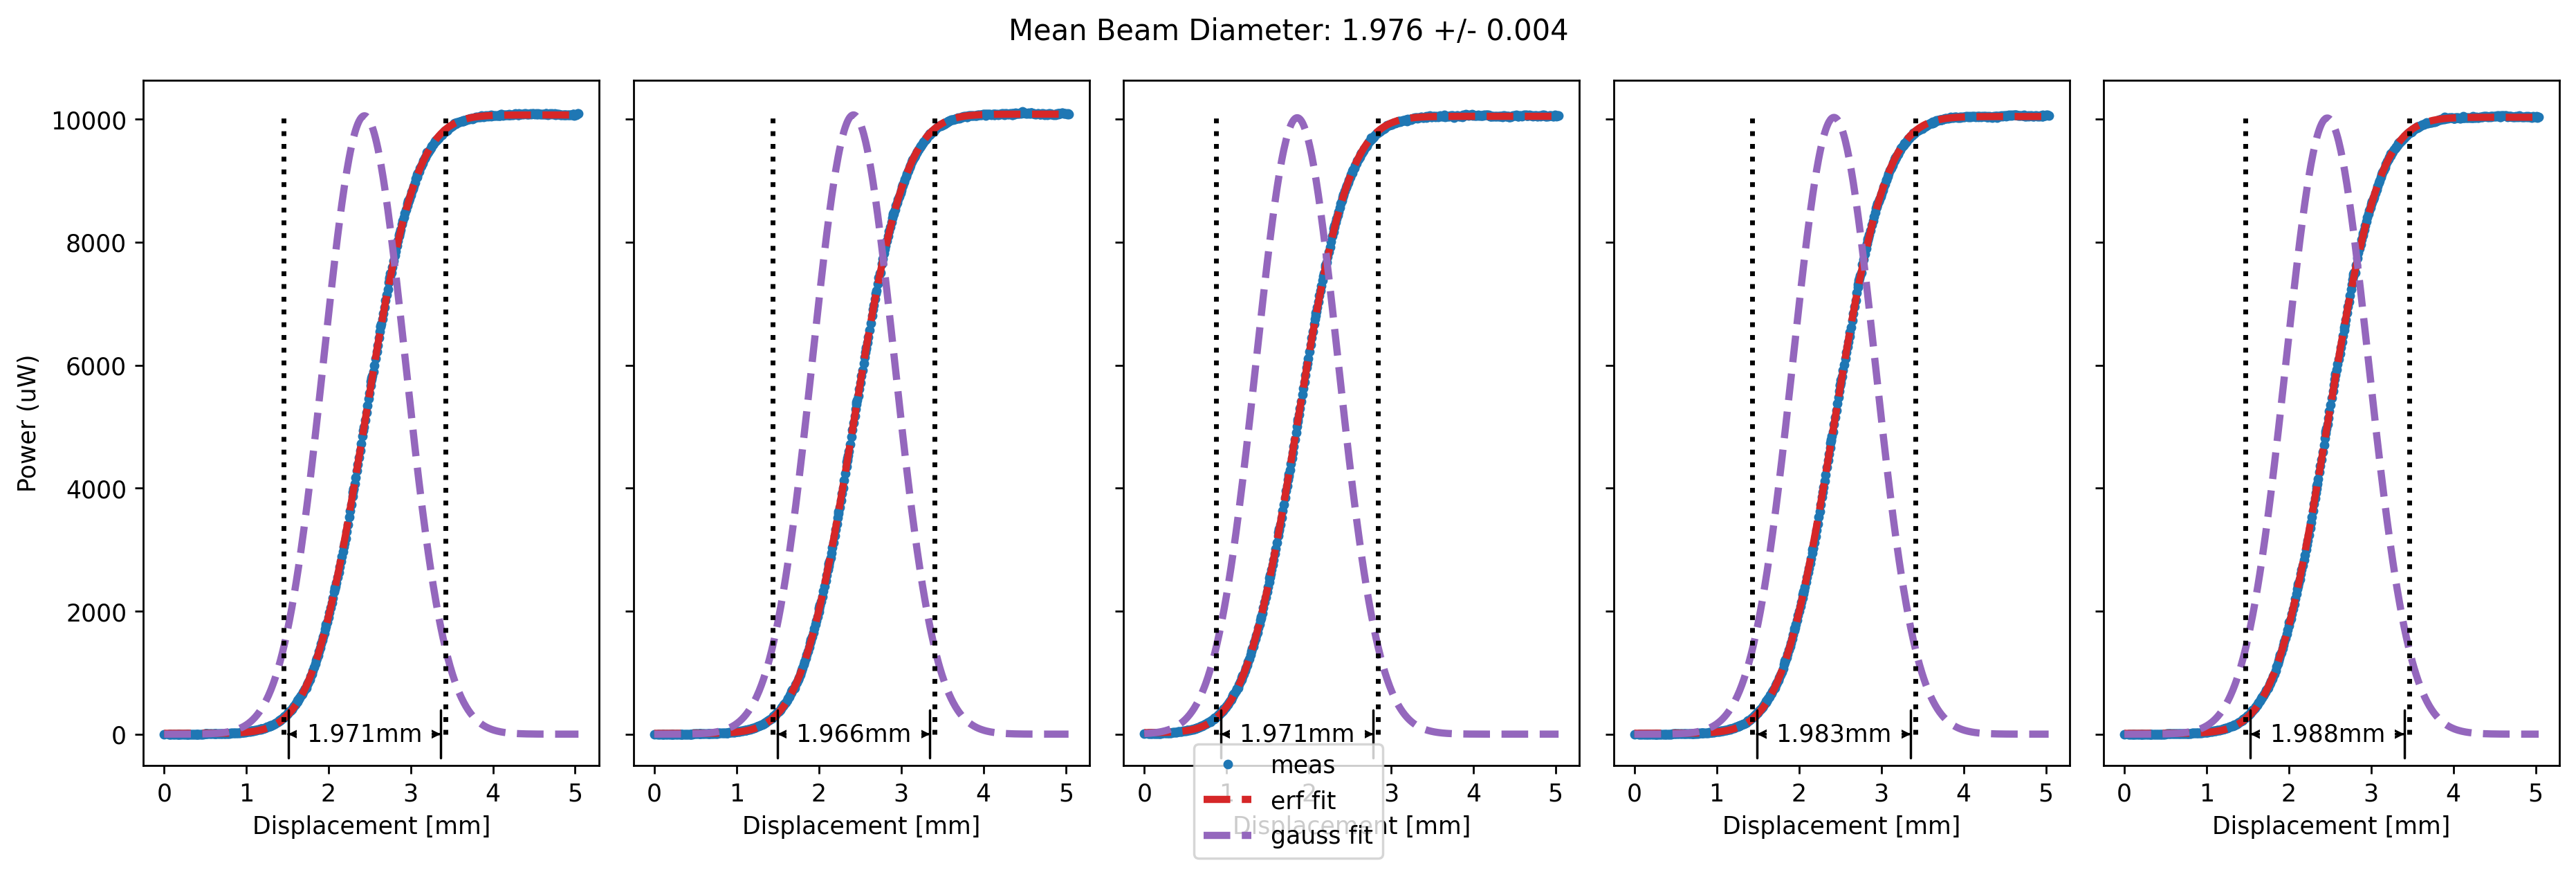

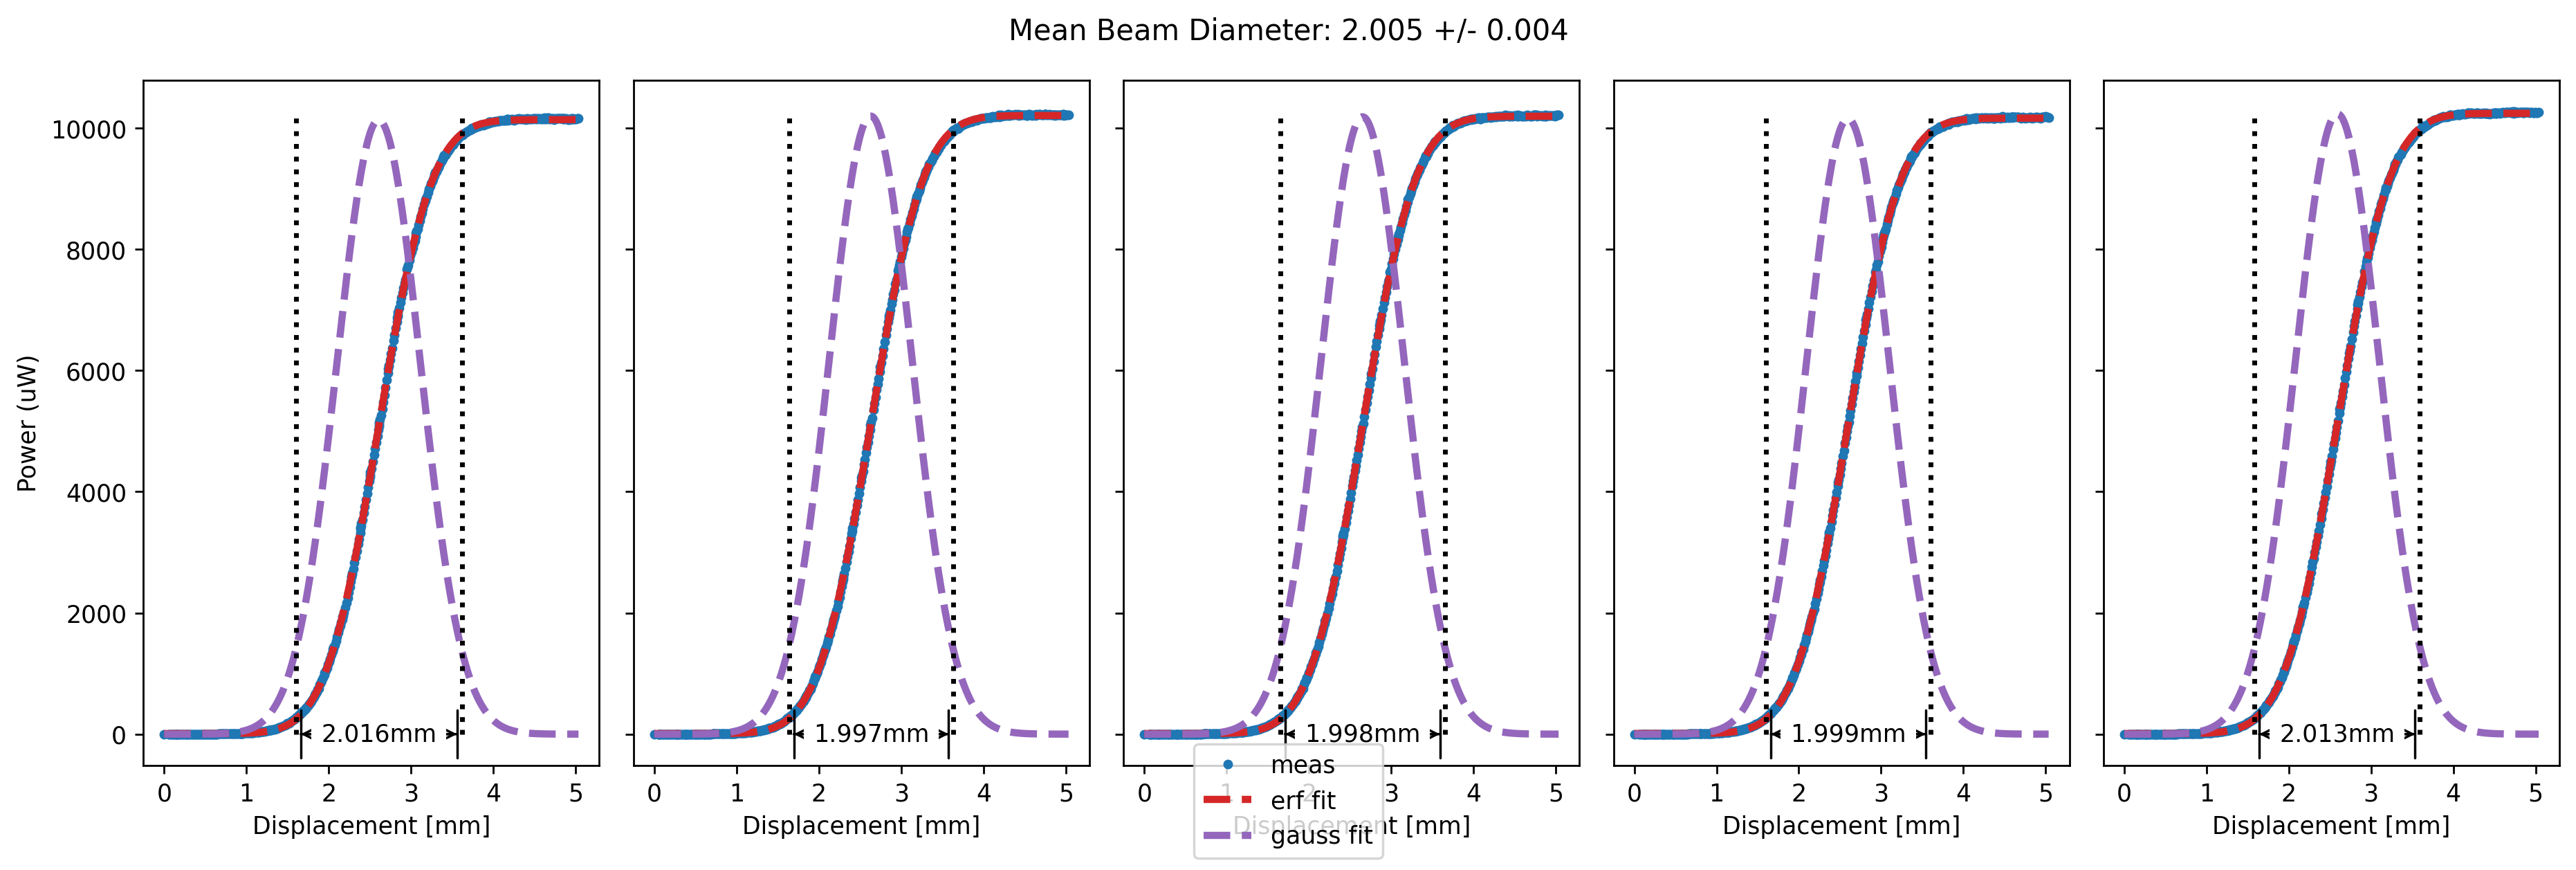

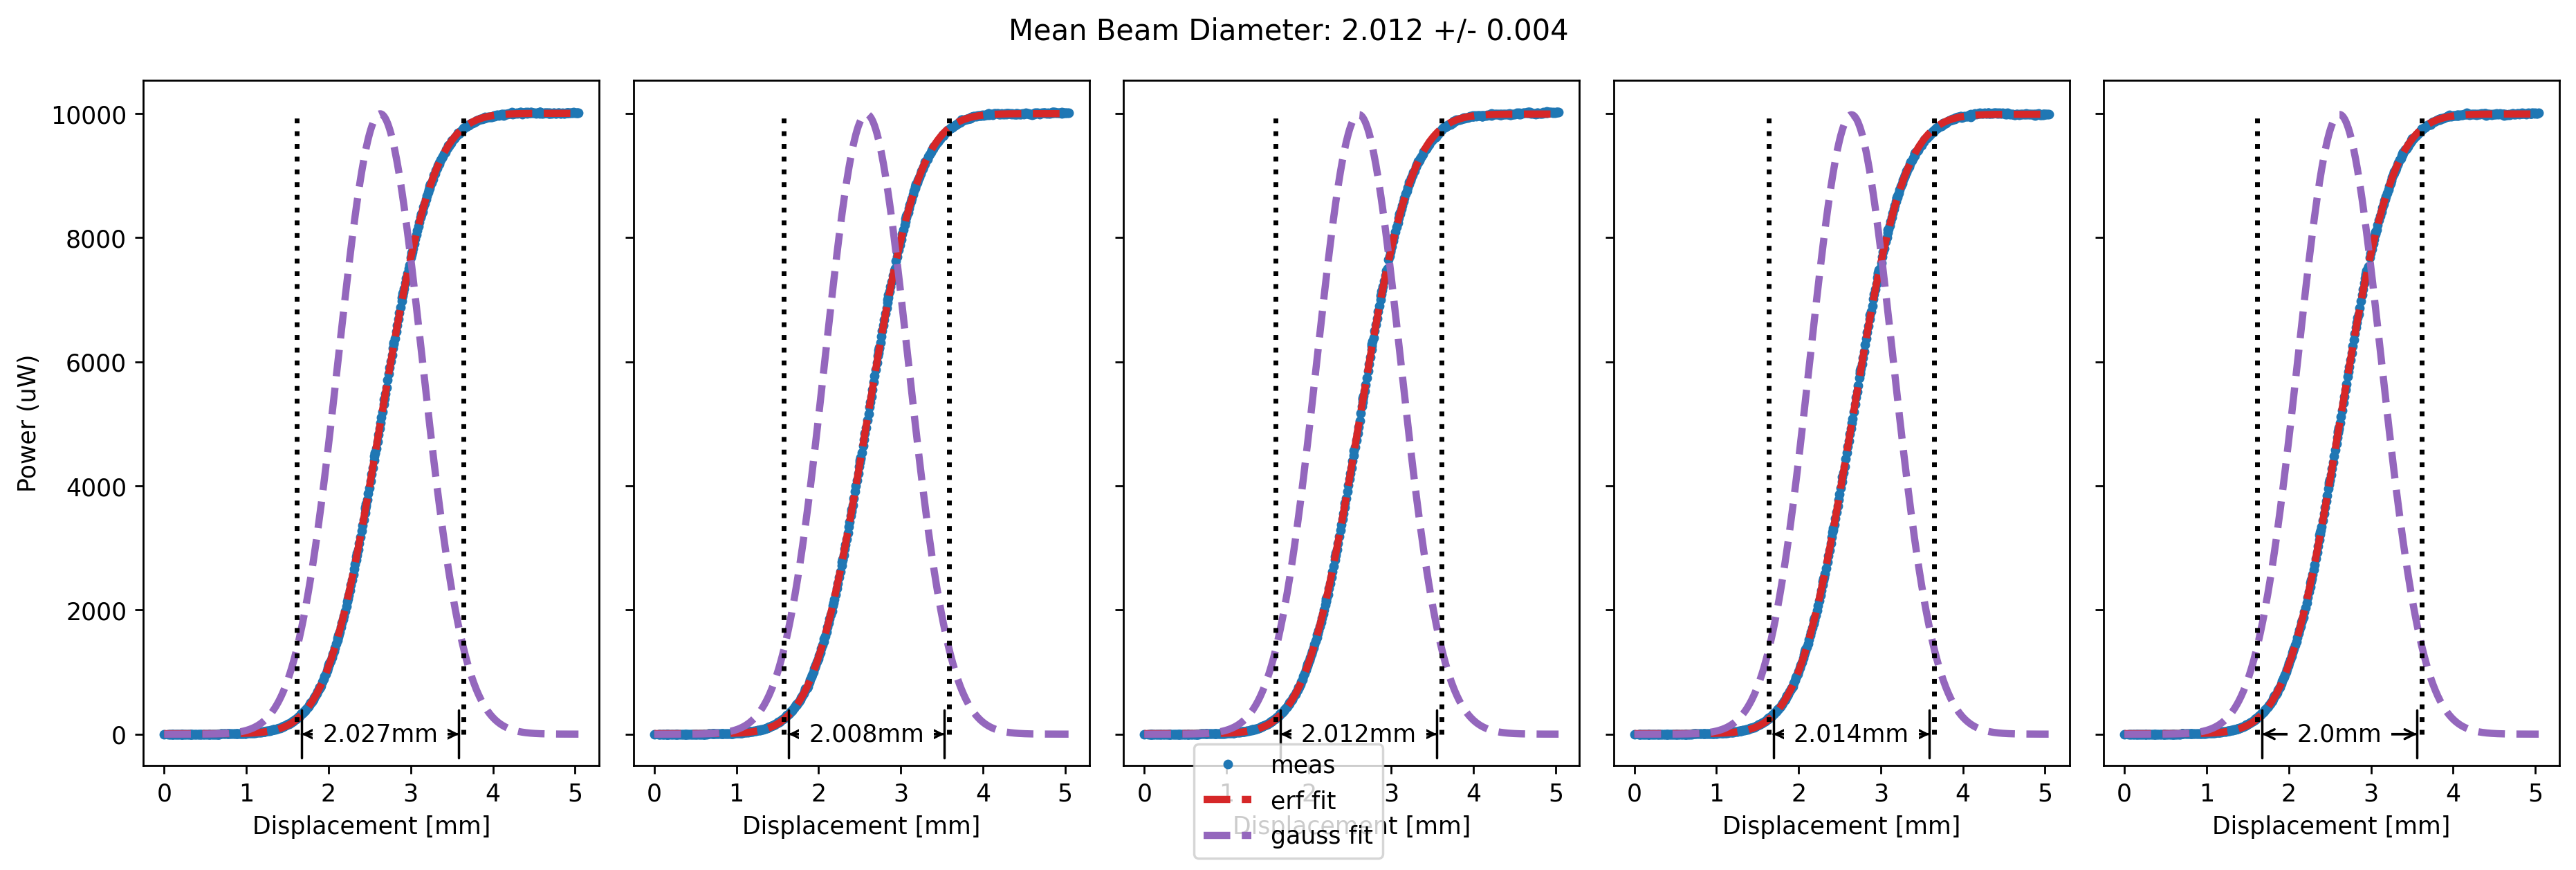

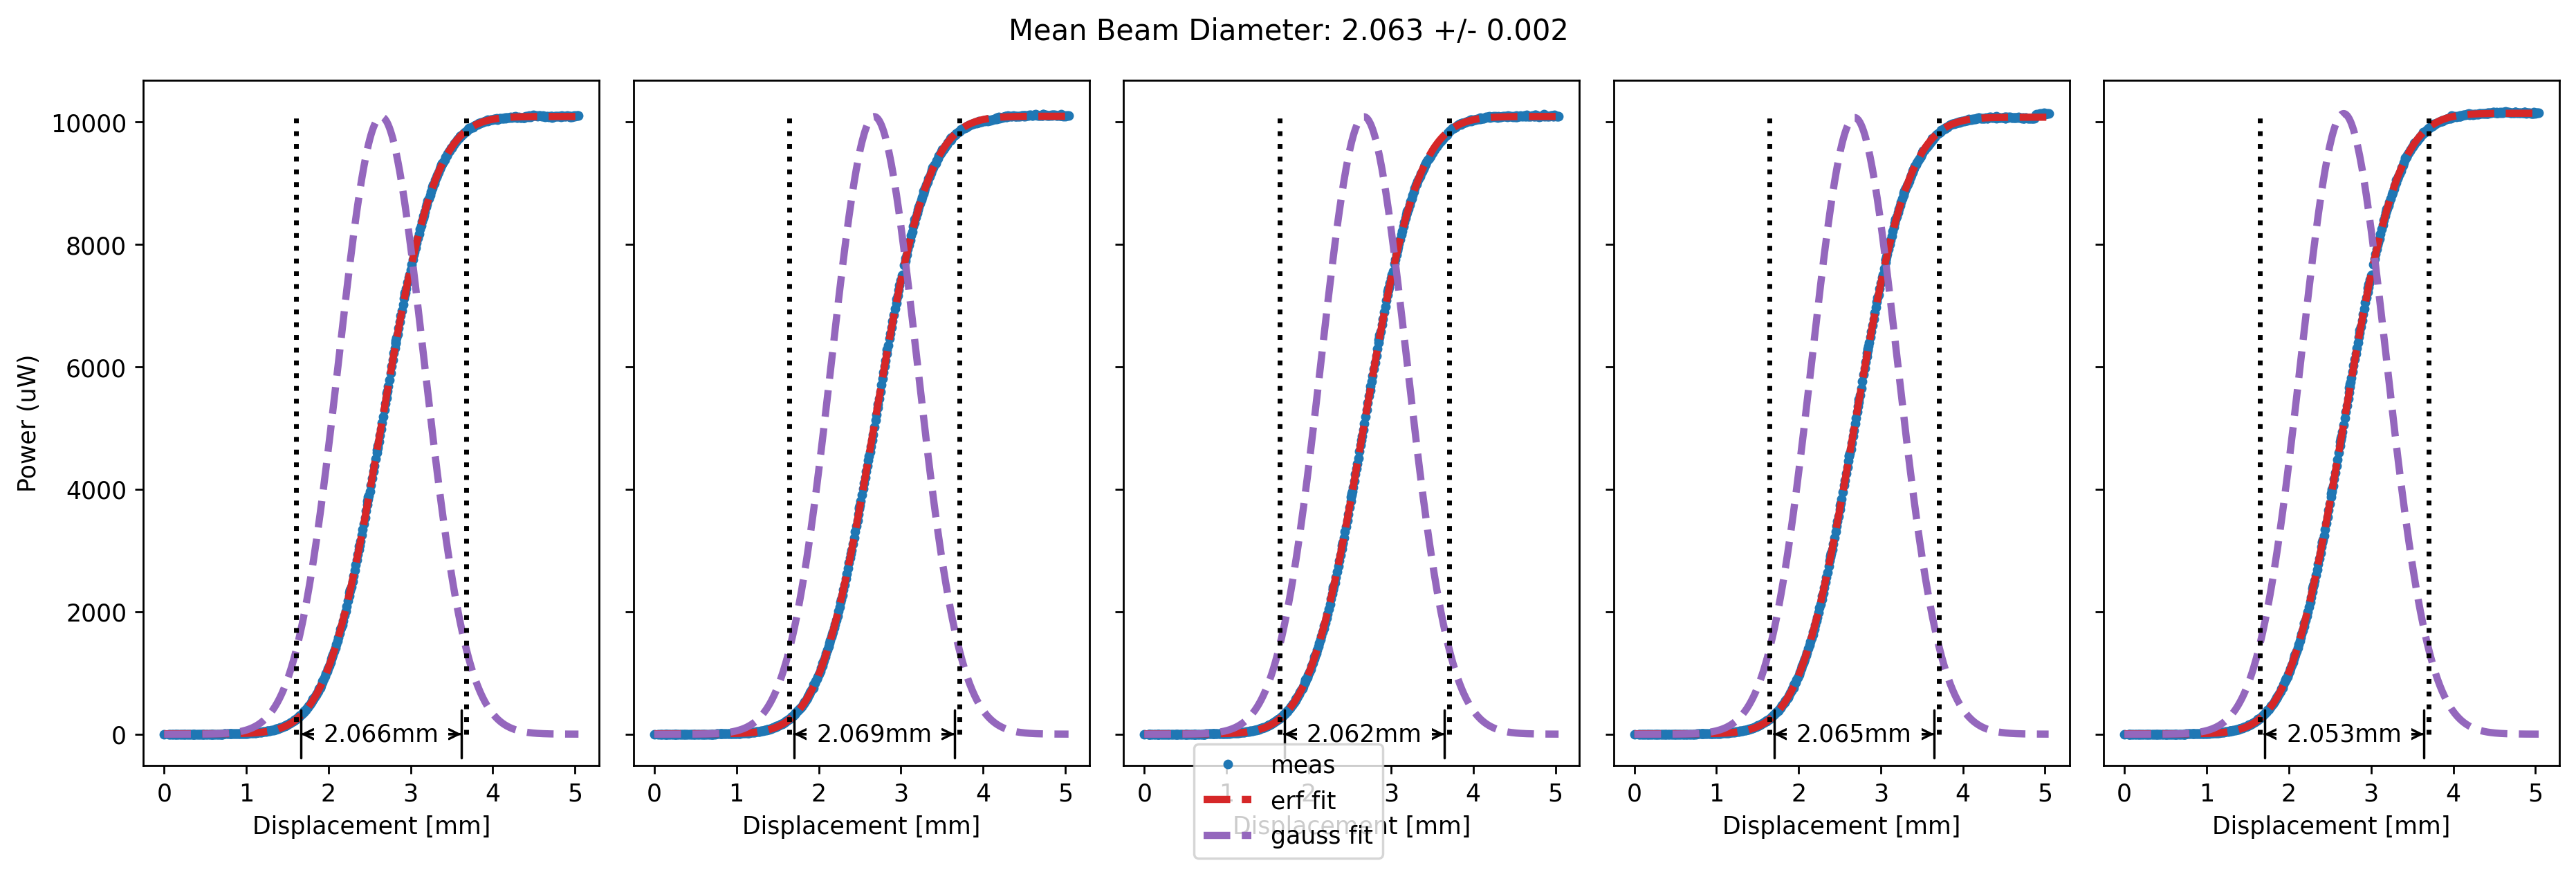

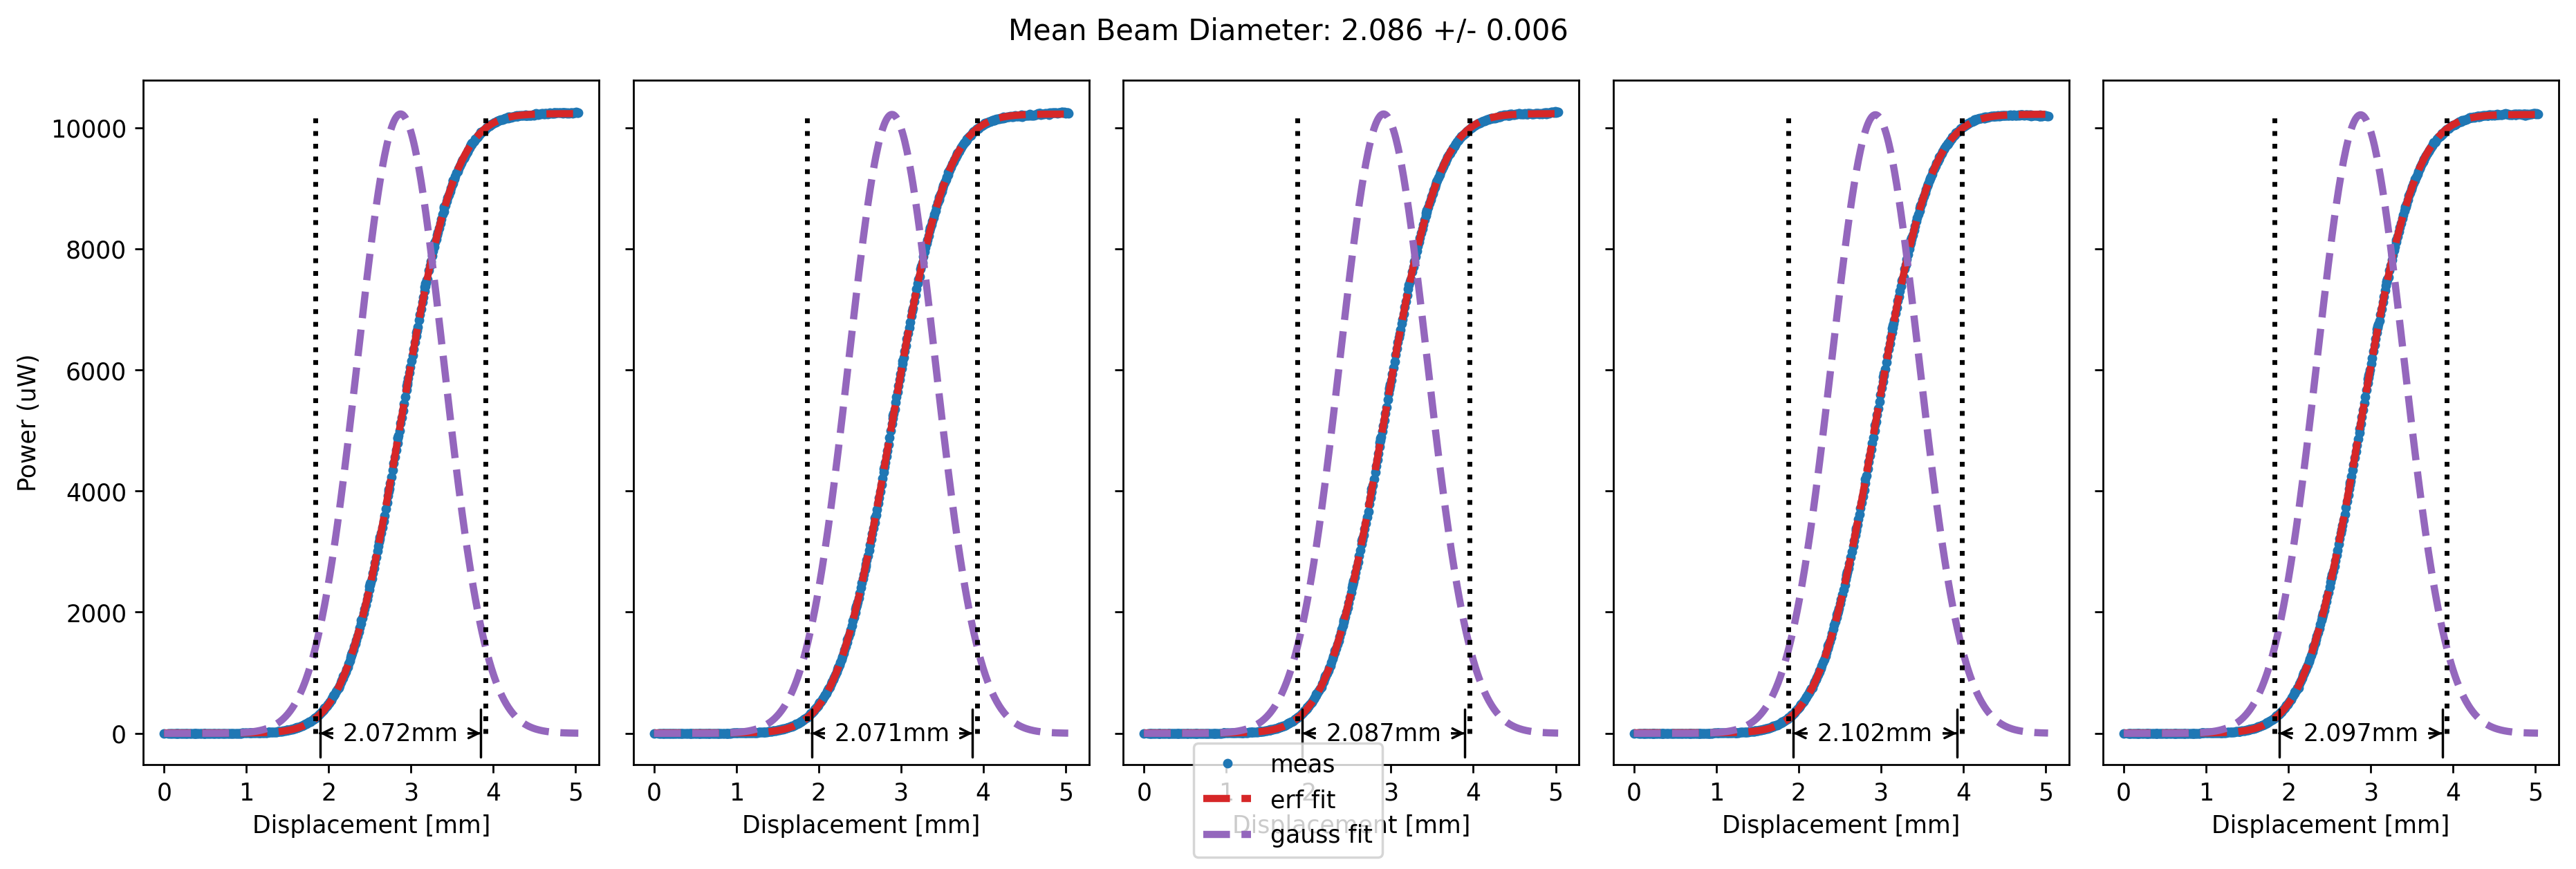

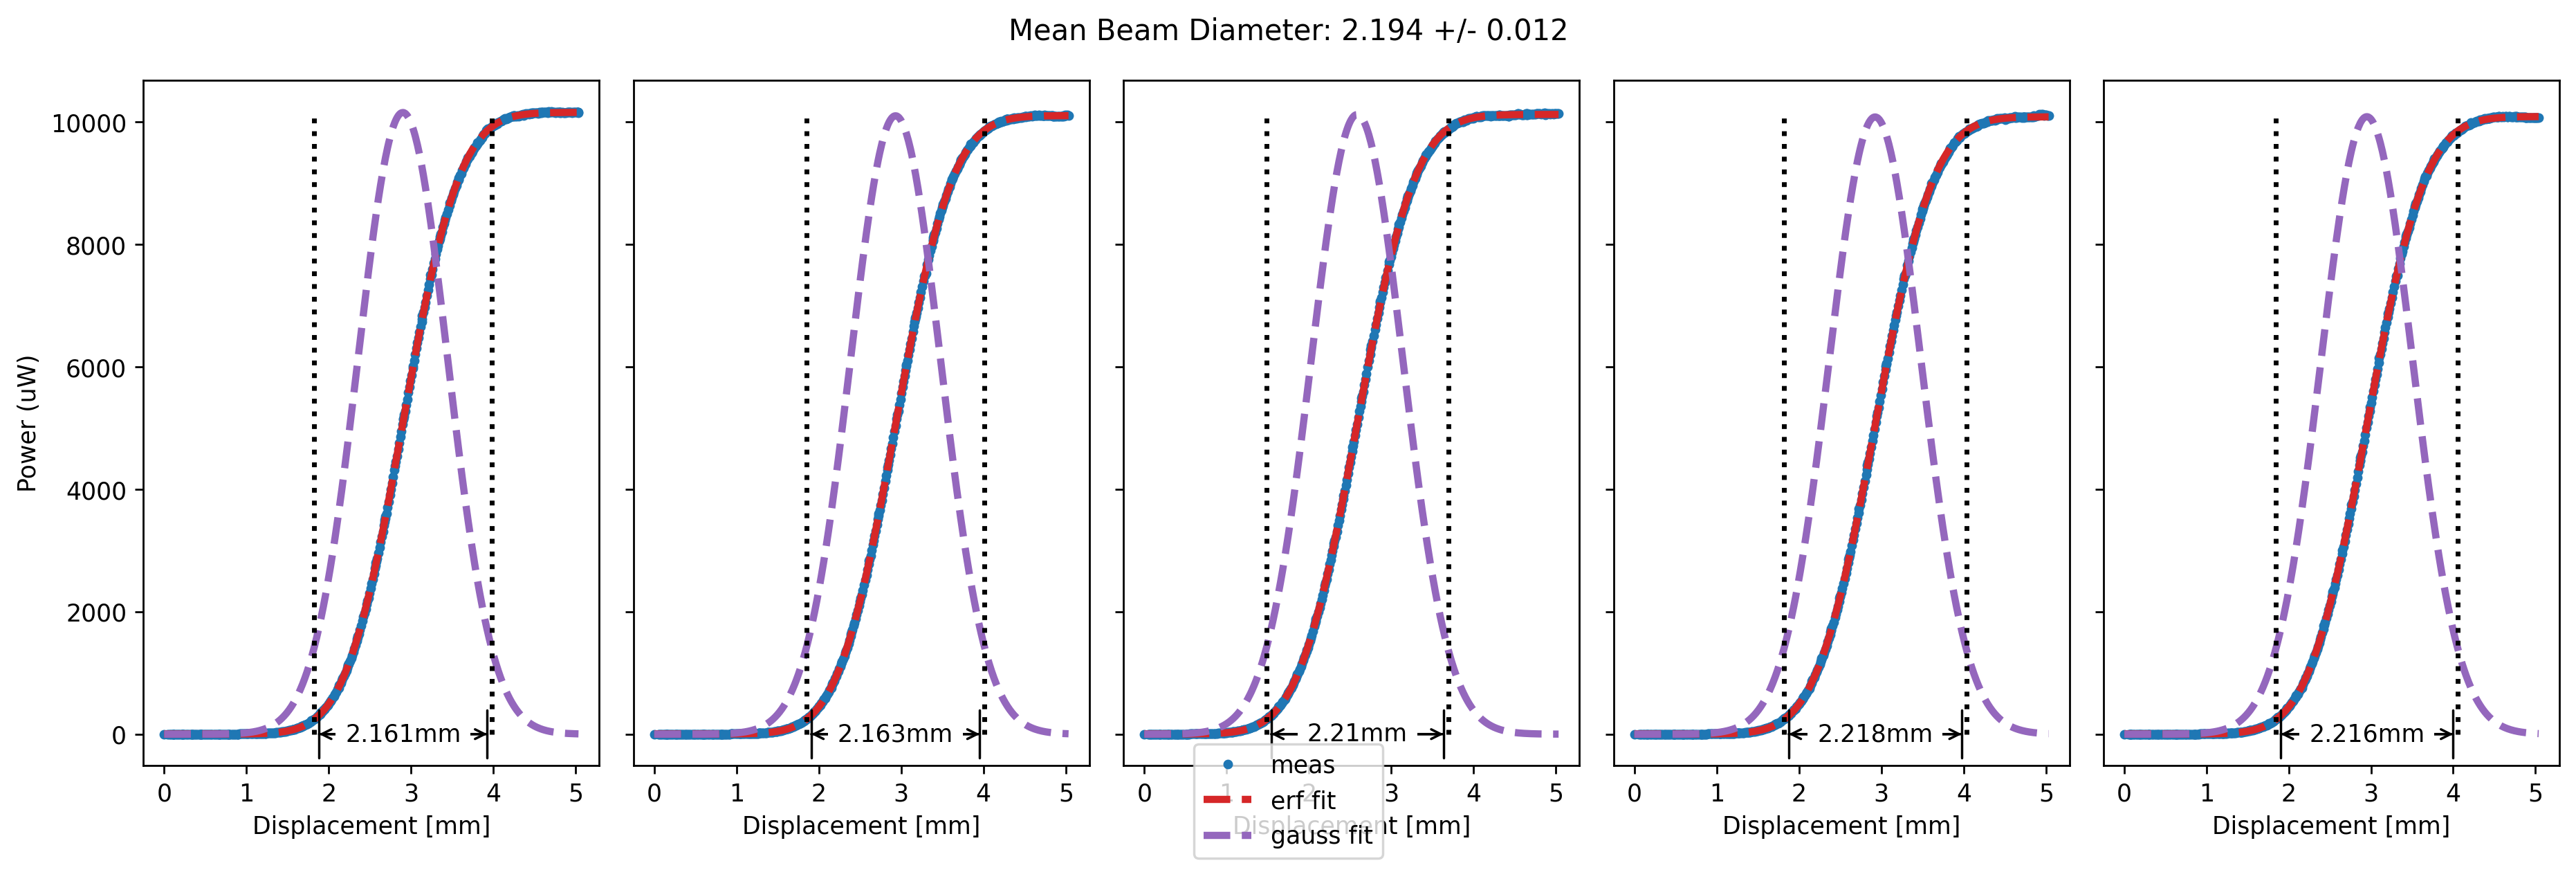

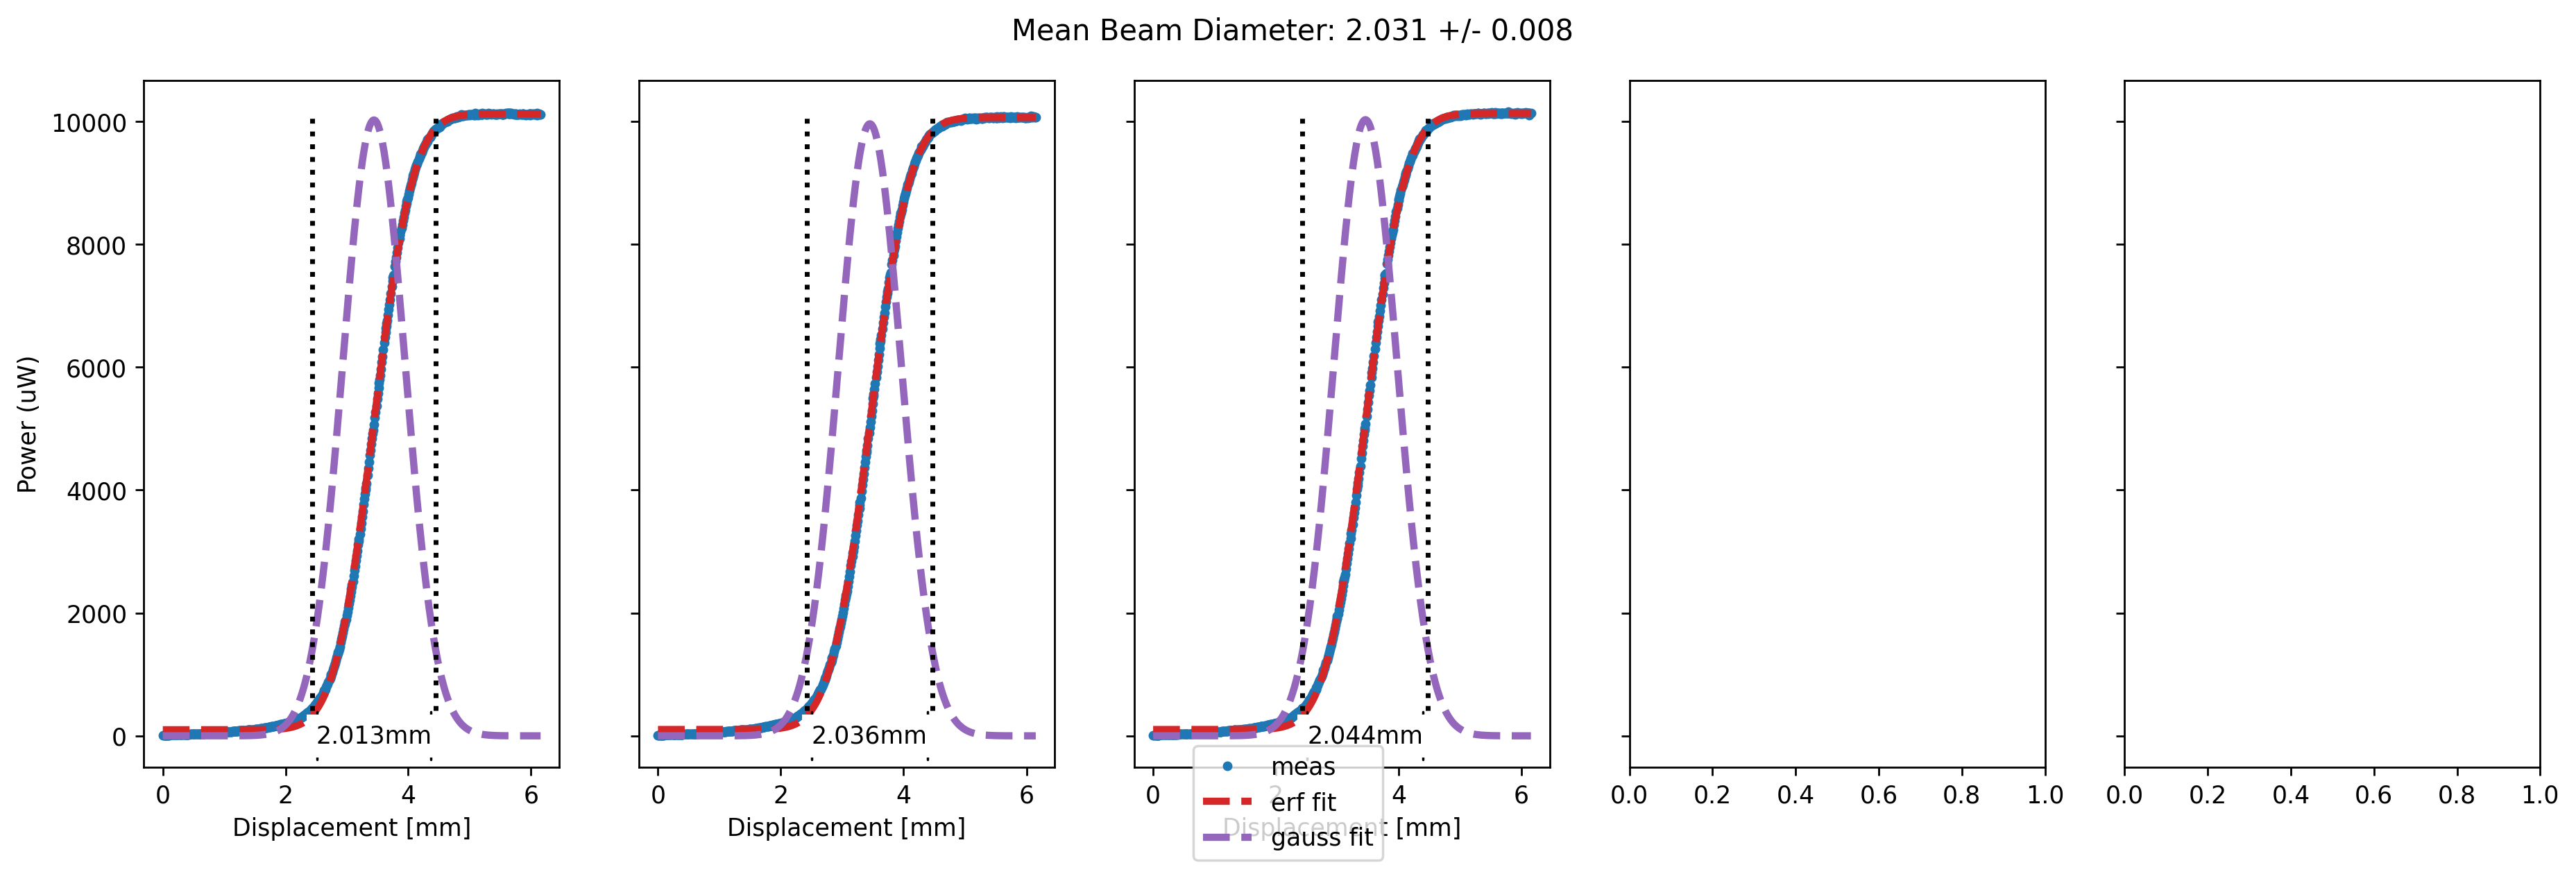

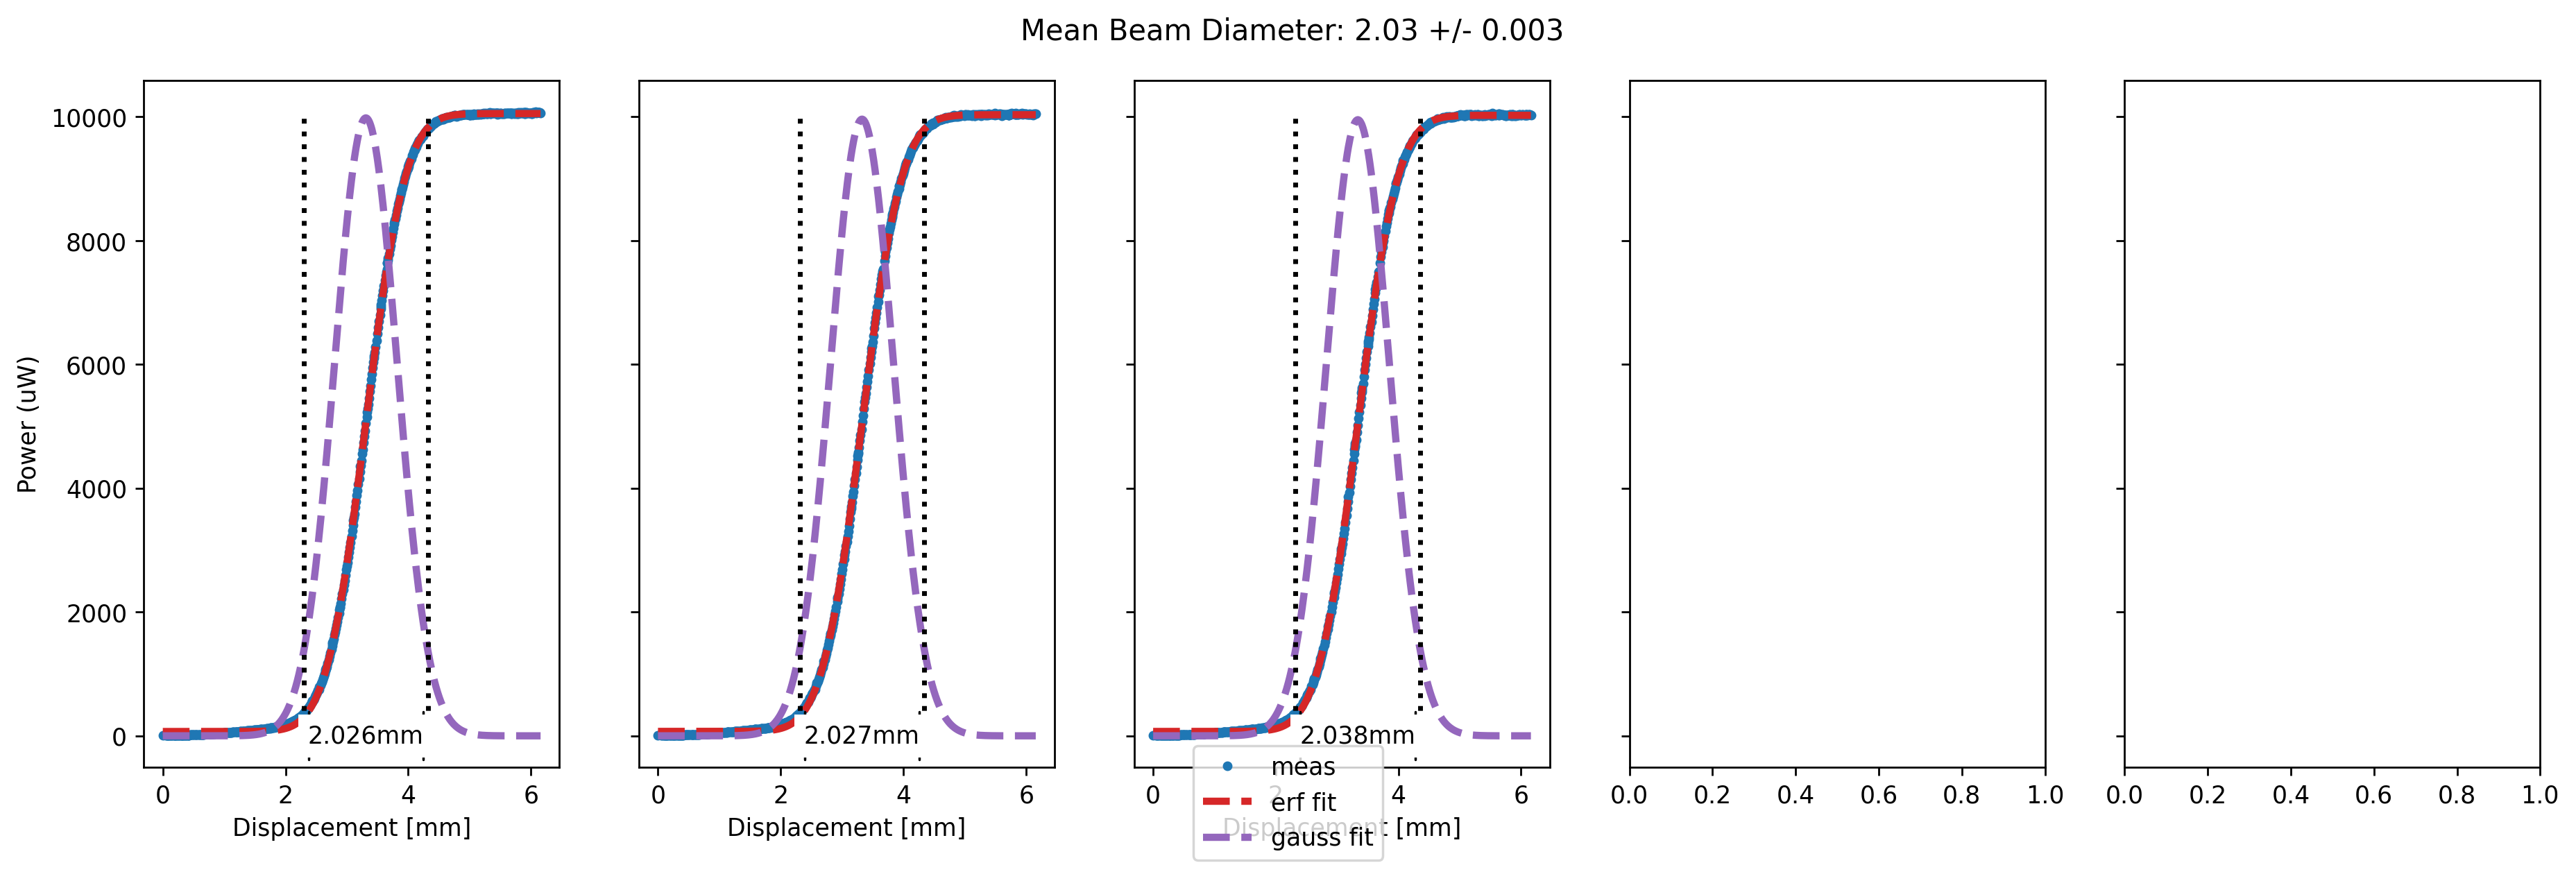

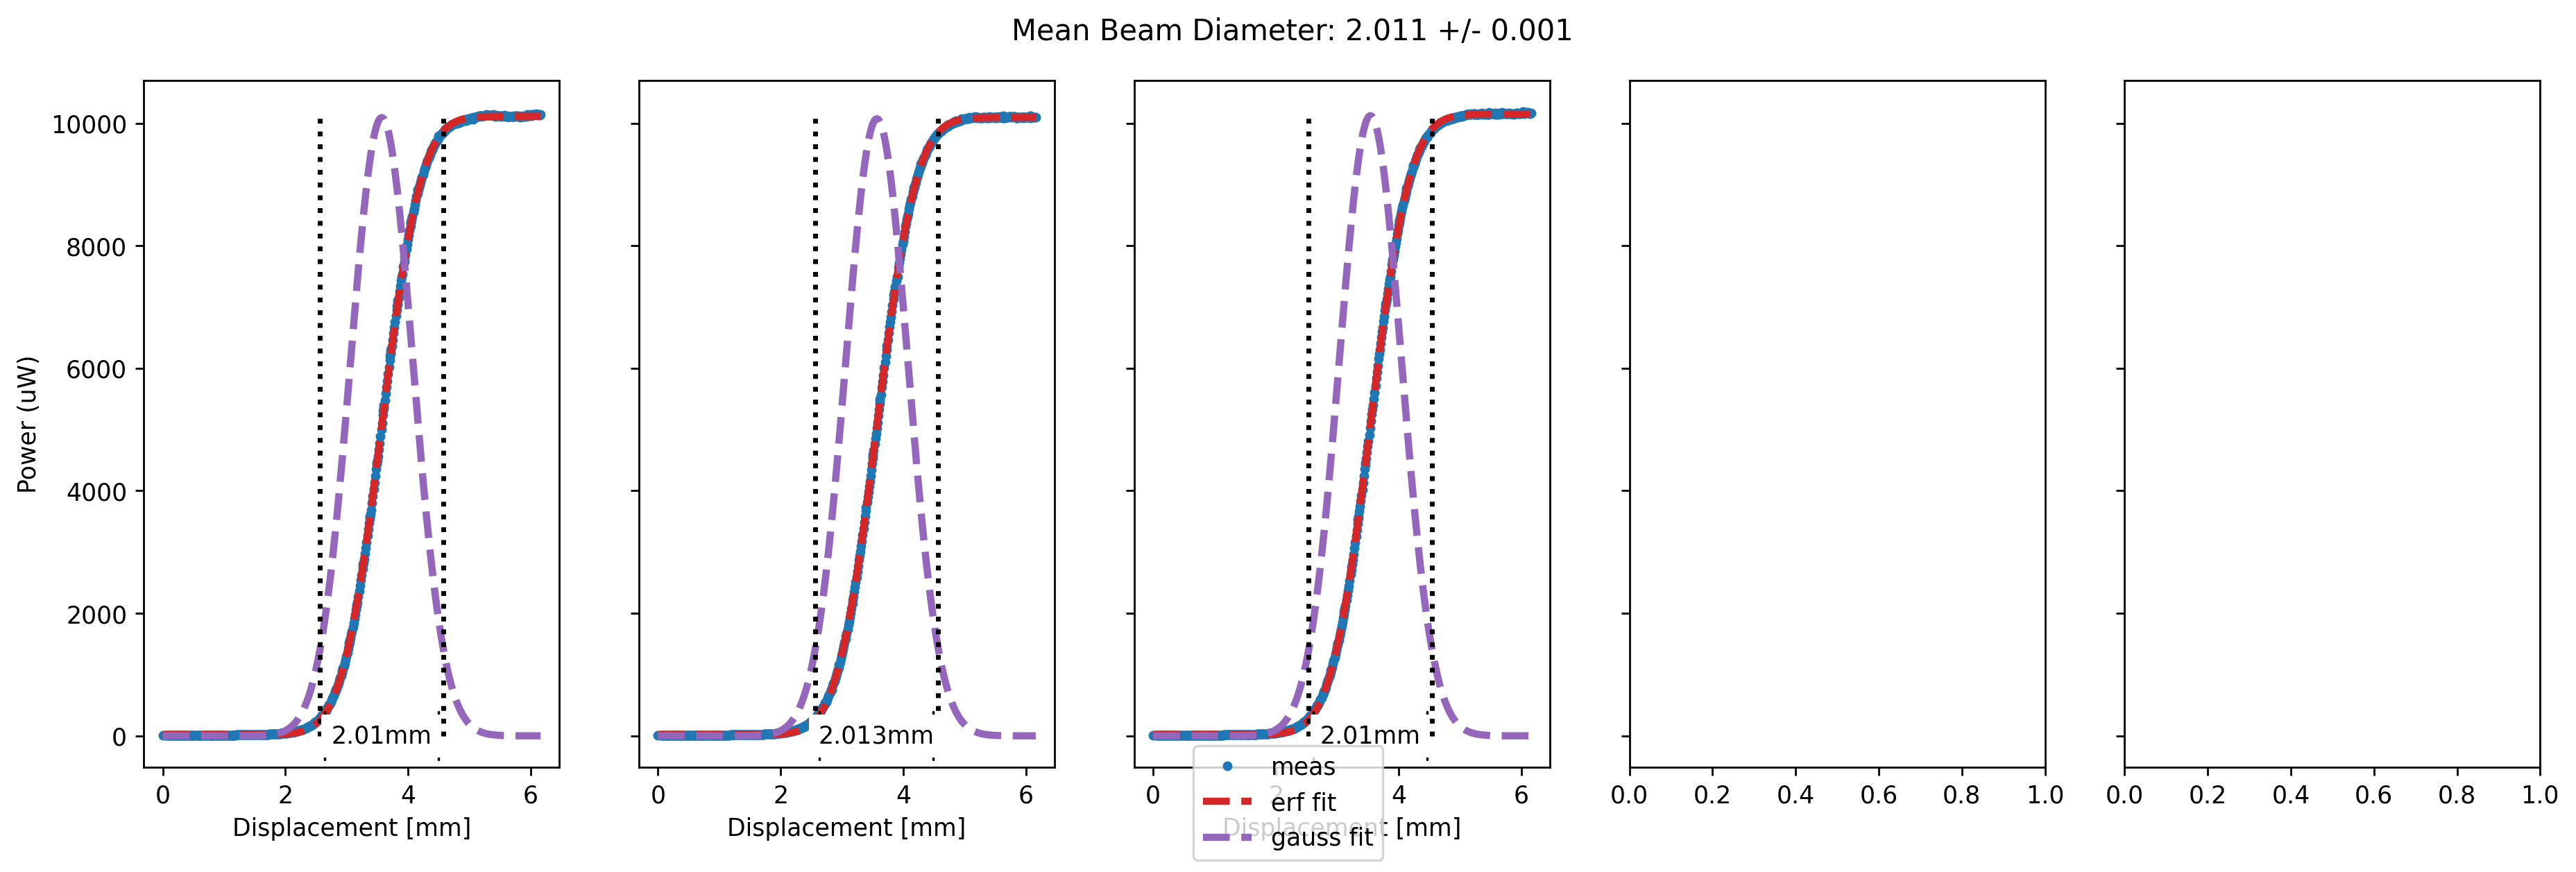

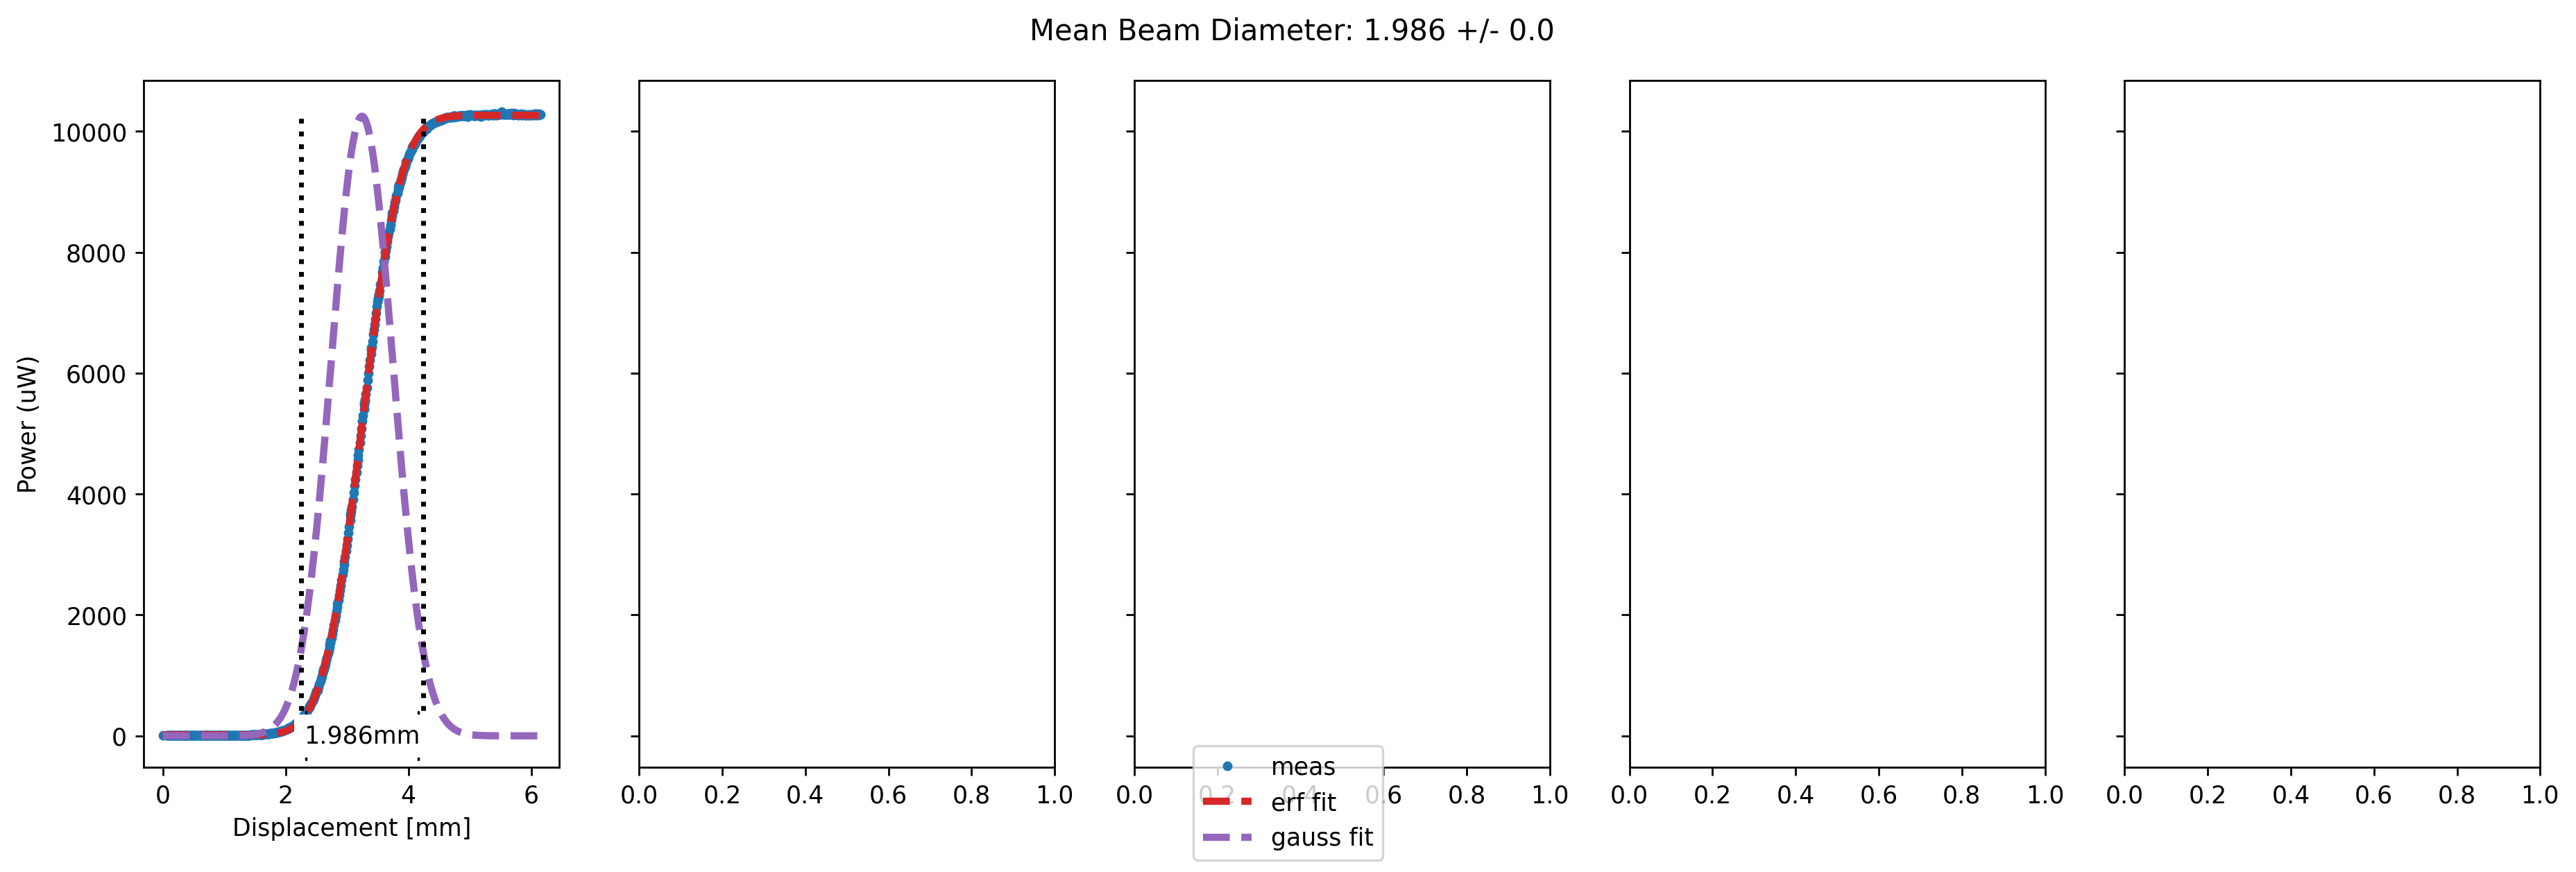

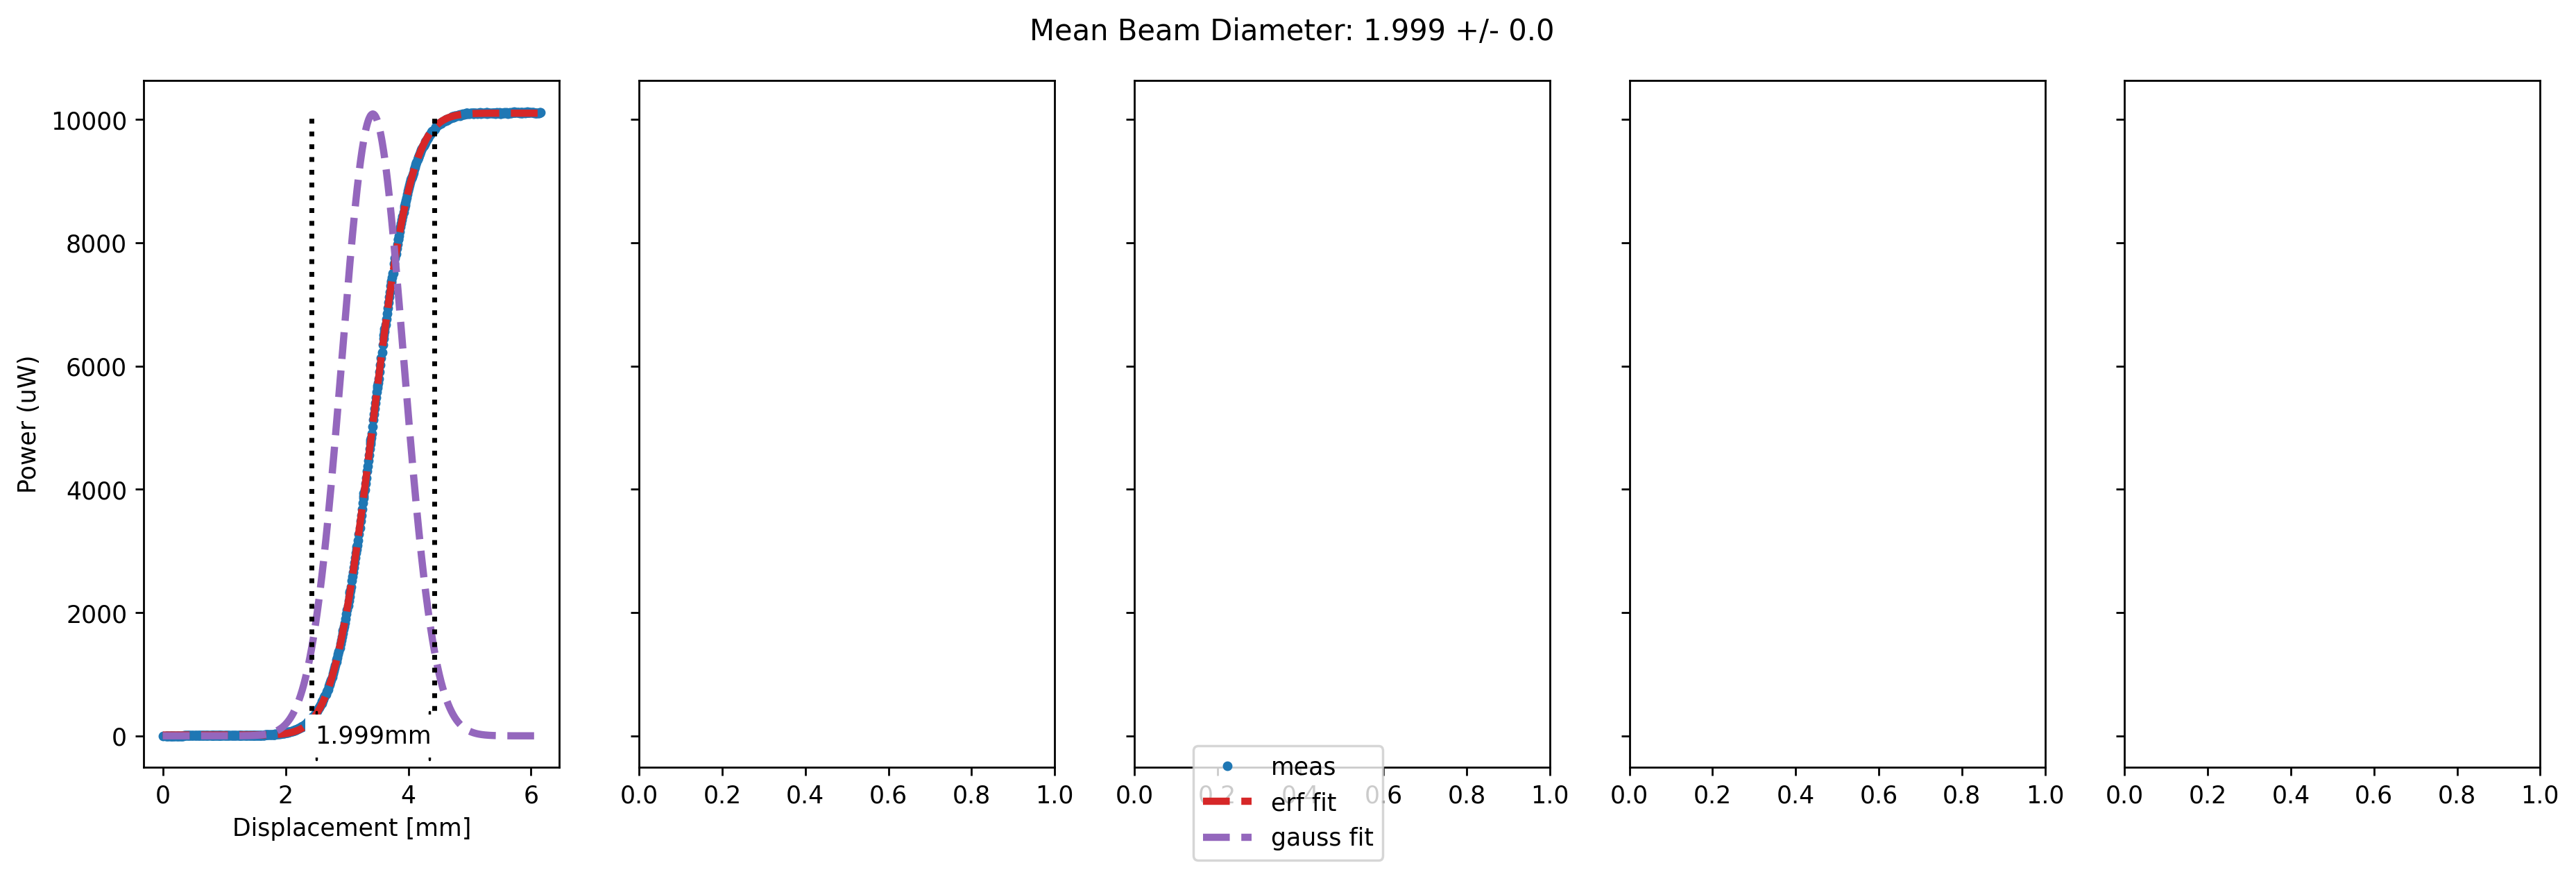

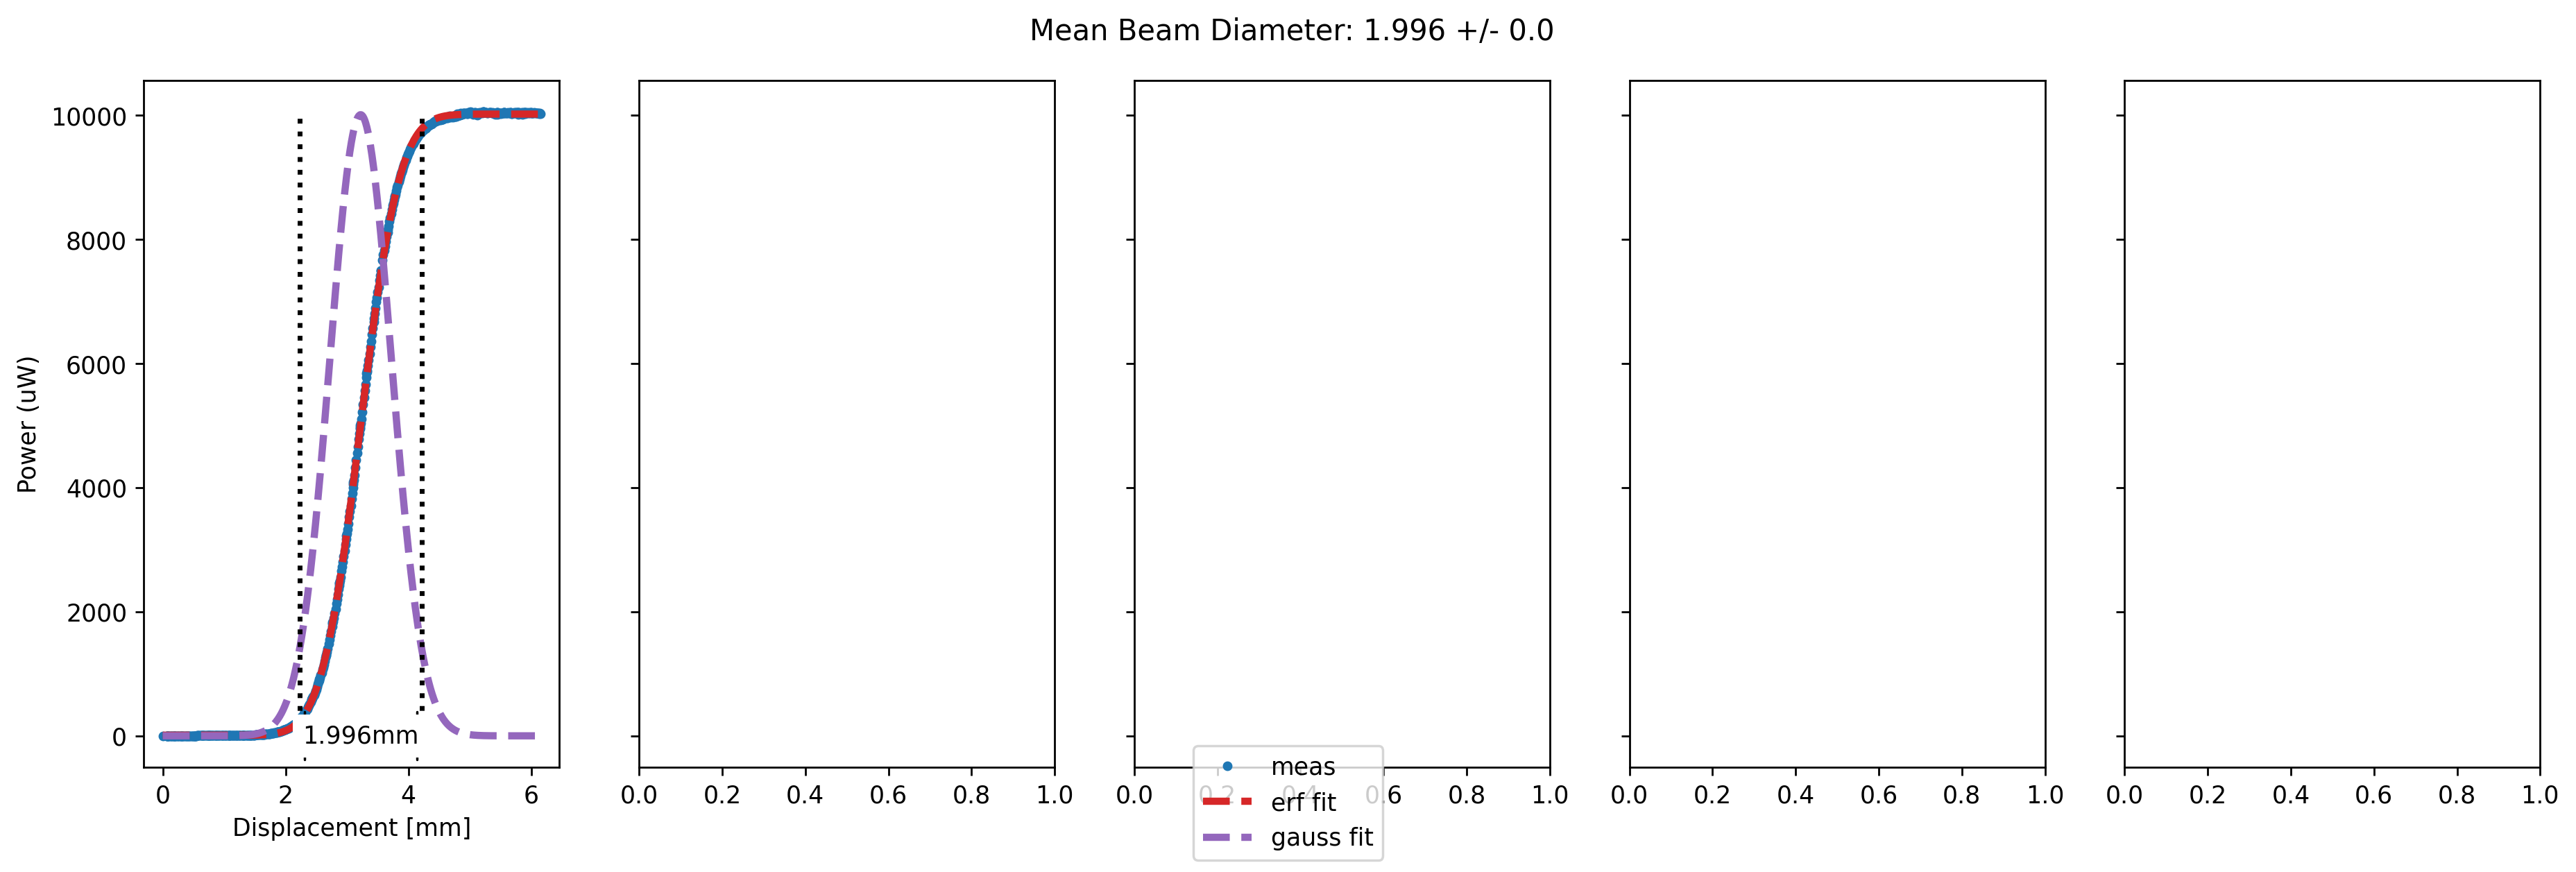

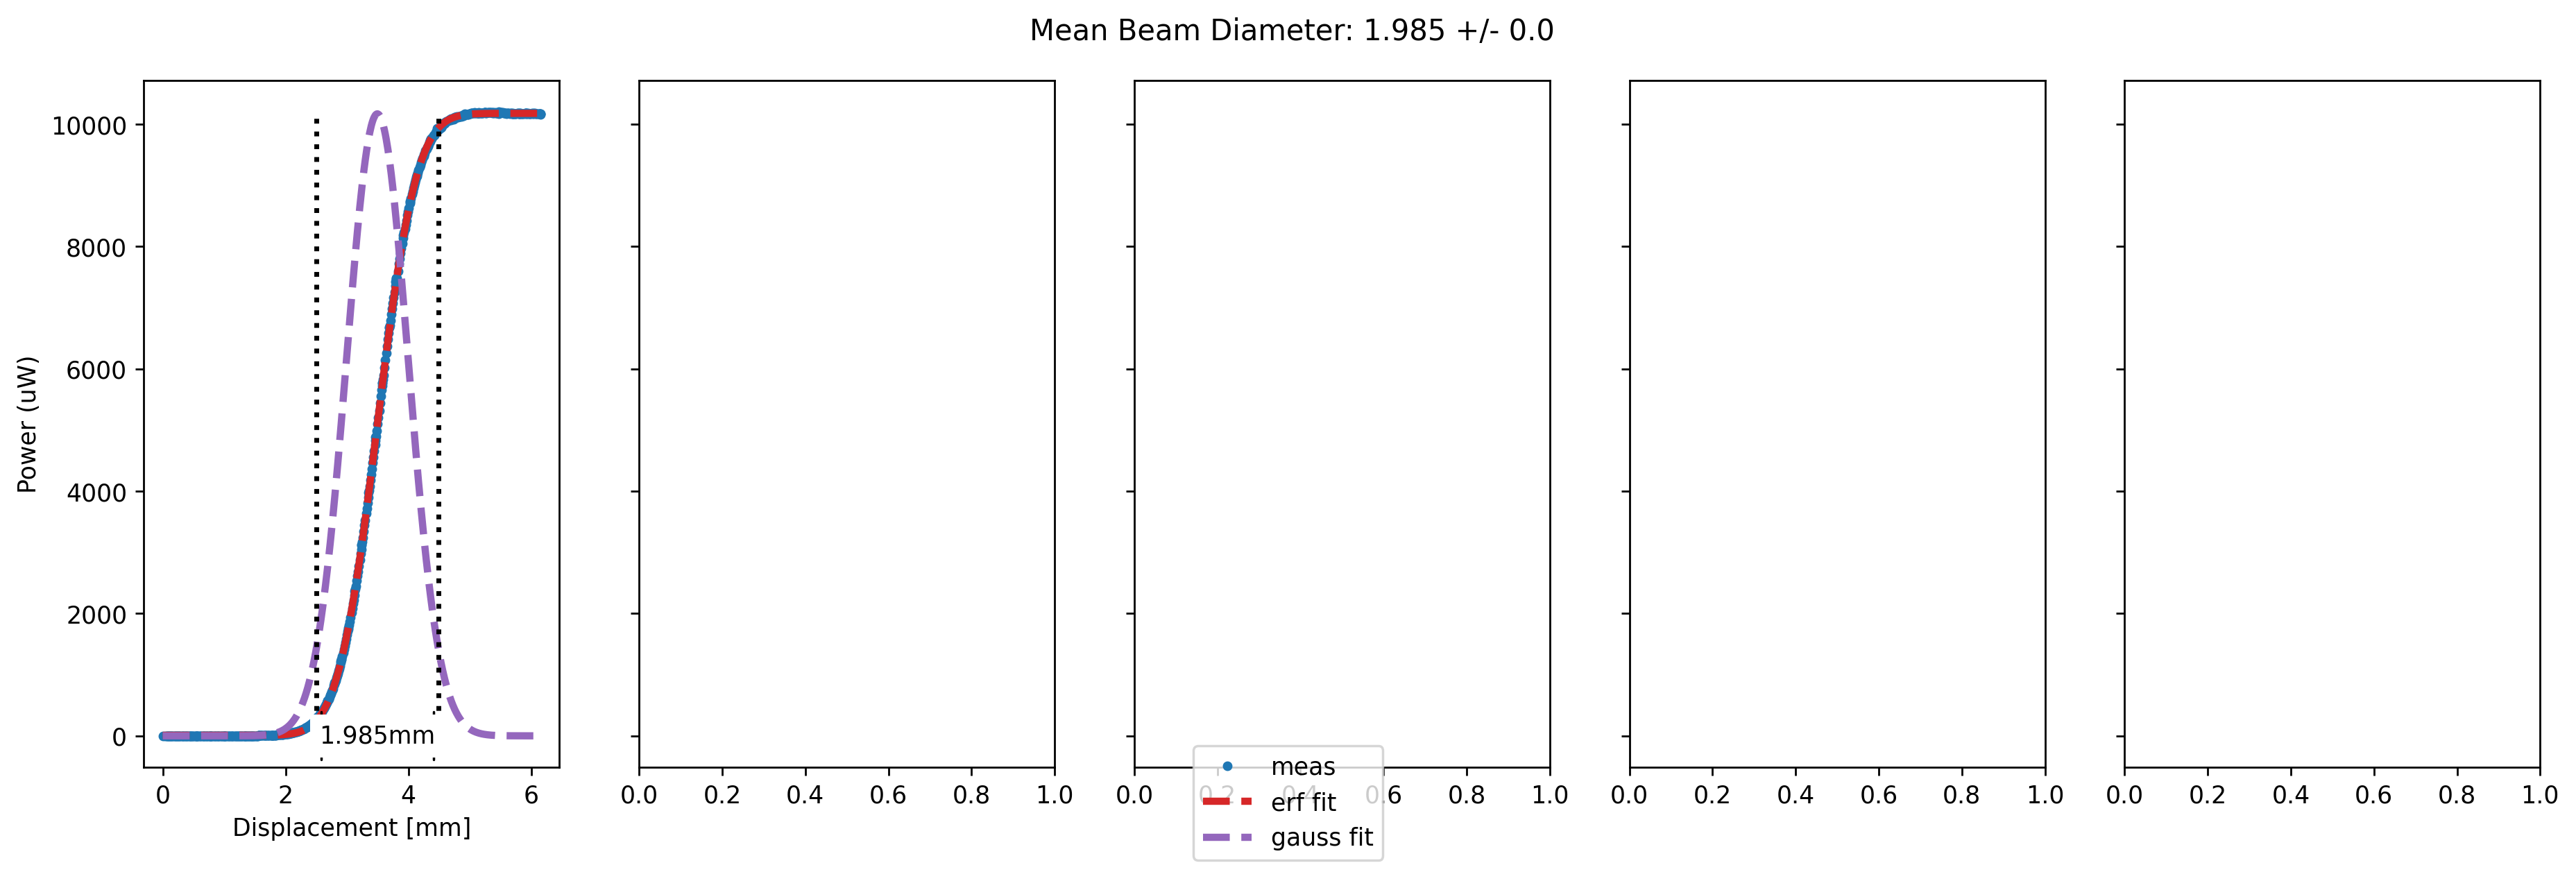

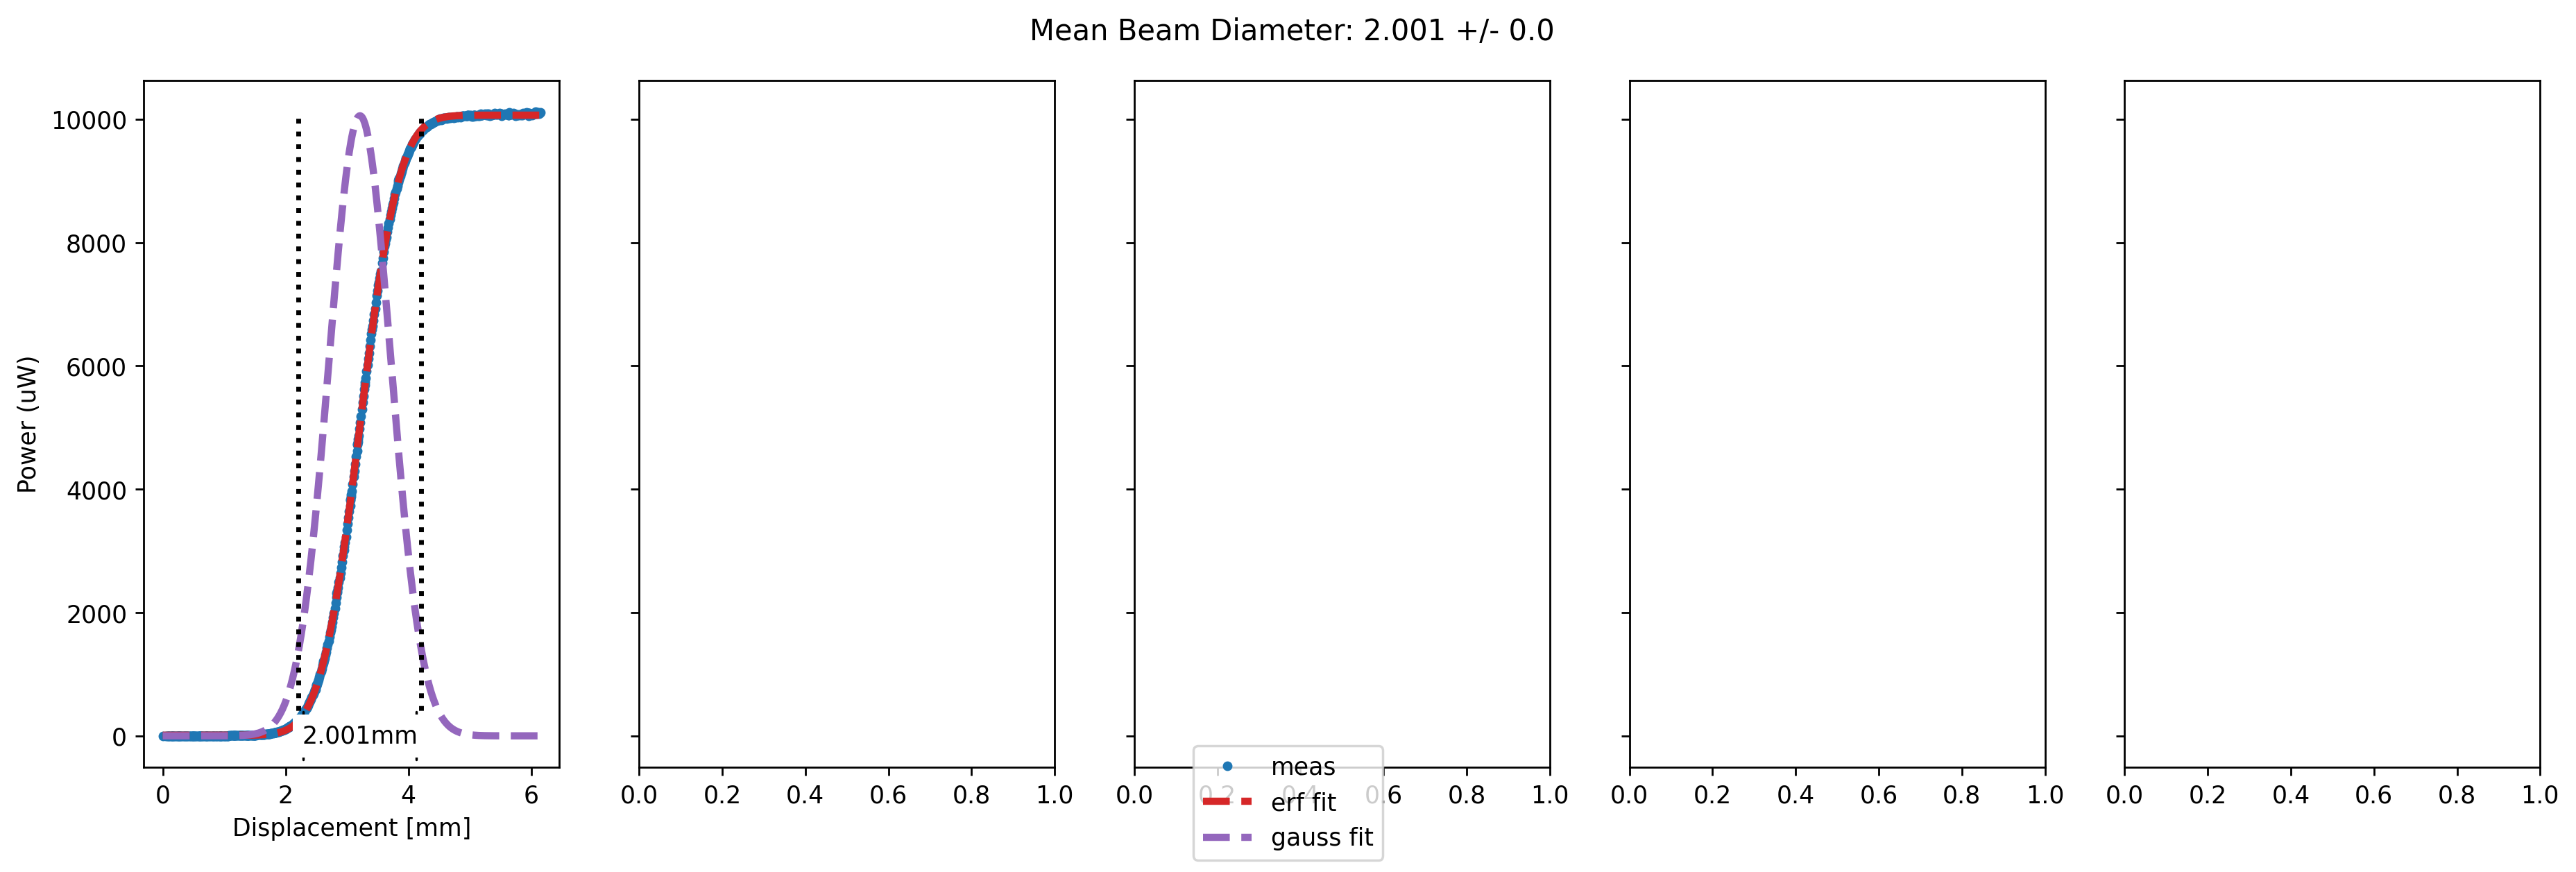

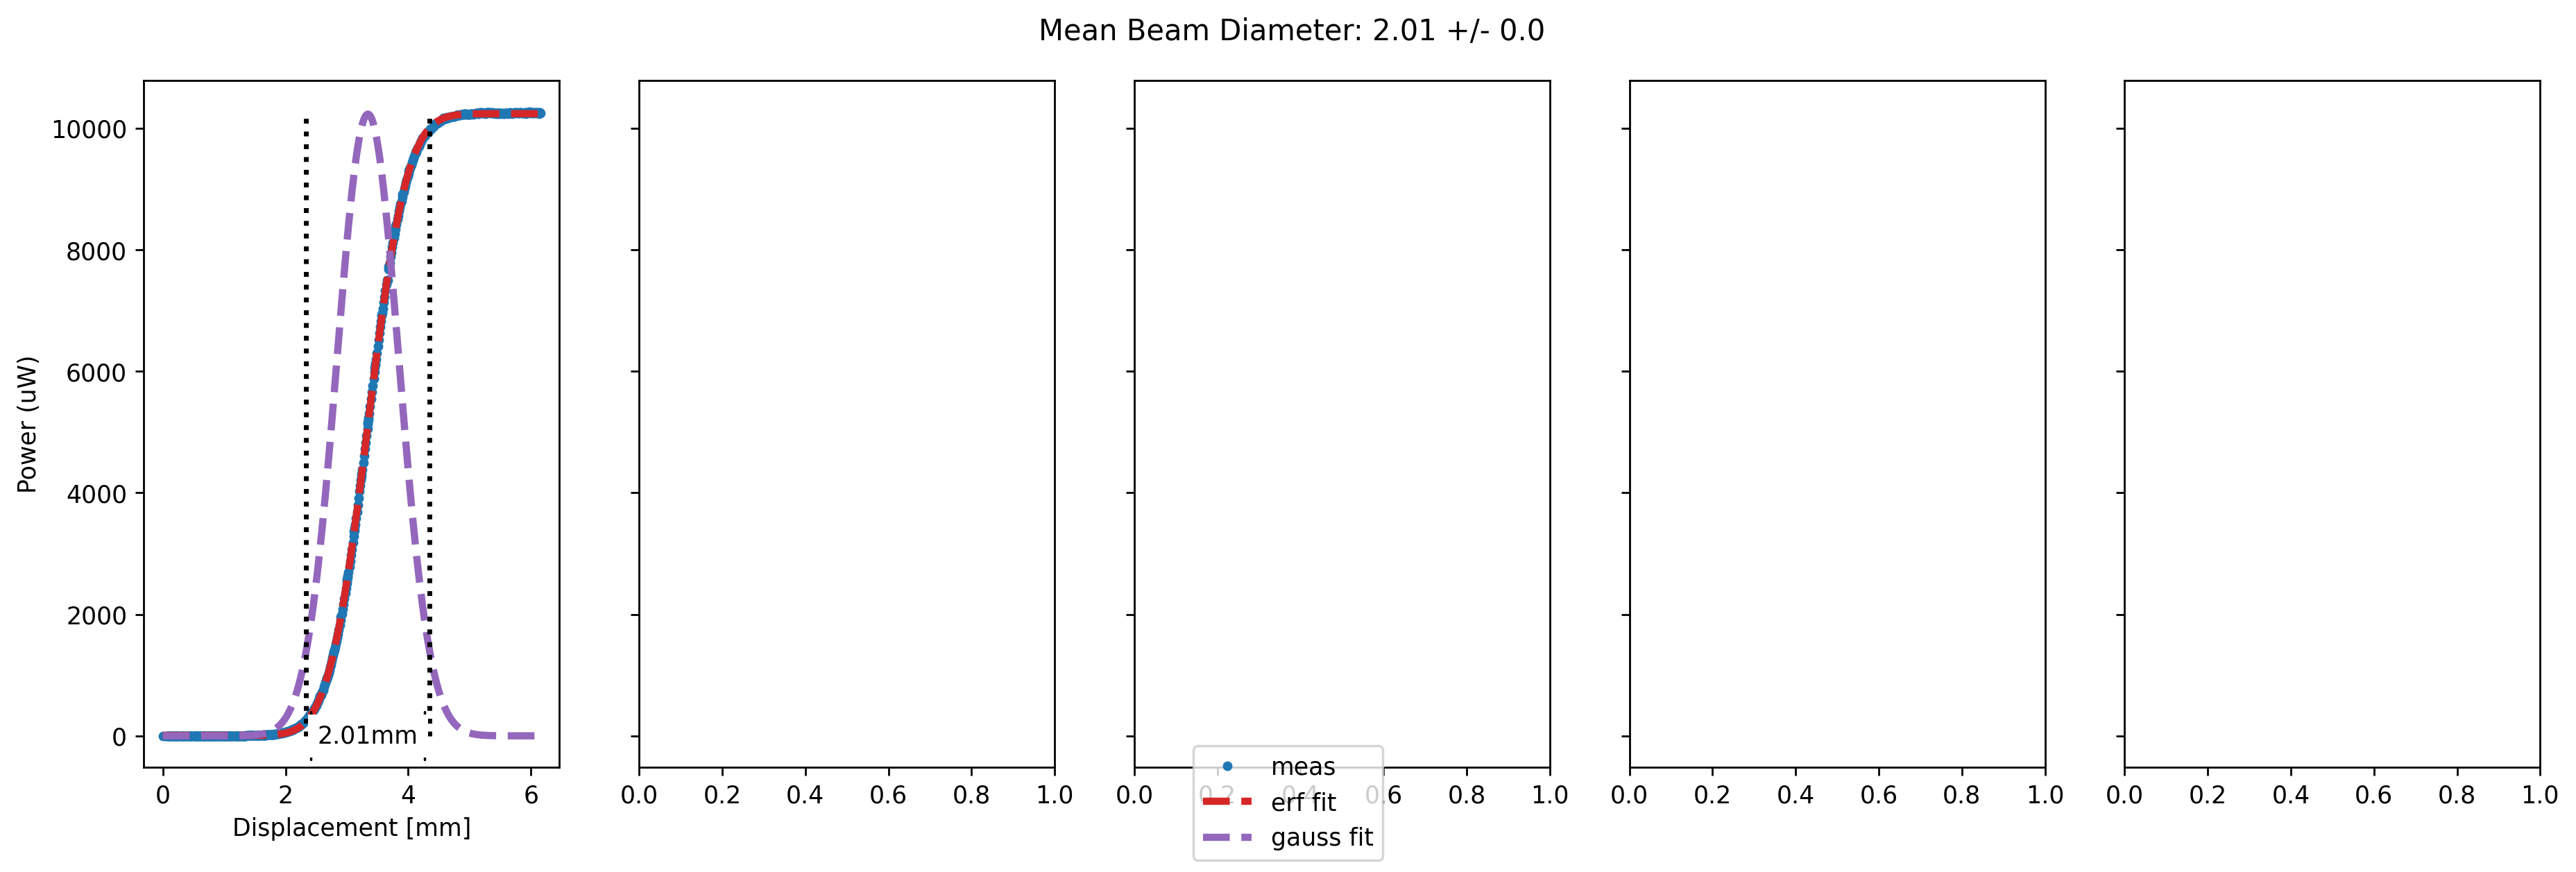

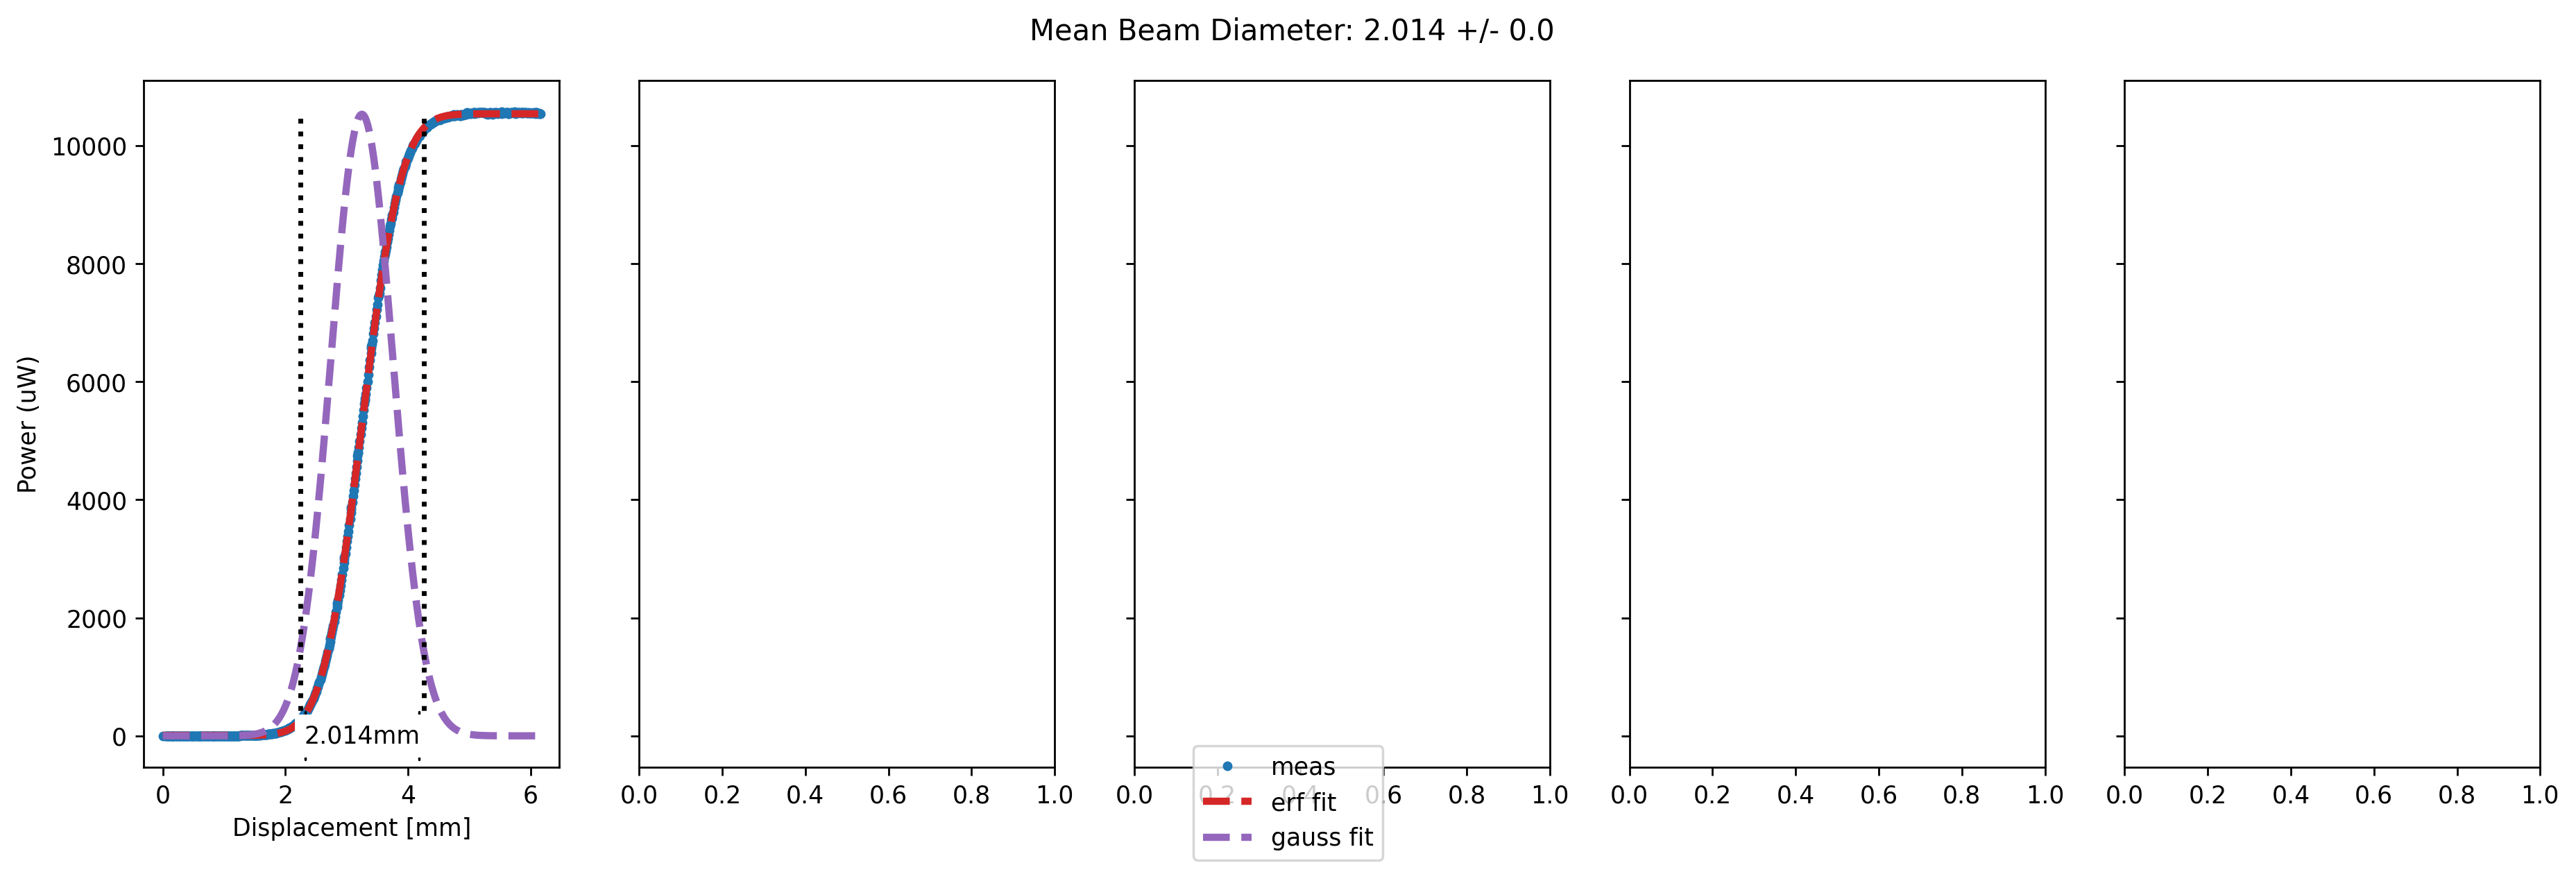

In [5]:
n_positions = 6

v_data = pd.DataFrame({
    "times": [1.59473, 1.5957, 1.49219, 1.52051, 1.50879, 1.57324, 1.51953, 1.59277, 1.51855, 1.51074, 1.49121, 1.52734, 1.57129, 1.57031, 1.60059, 1.45312, 1.52051, 1.47558, 1.60742, 1.63379, 1.47363, 1.48437, 1.51465, 1.53223, 1.58301, 1.52246, 1.45117, 1.56933, 1.48144, 1.53027, 1.47168, 1.57812, 1.58398]
})
velocity_gp2 = (v_data
              .pipe(analyse.get_std_of_times)
              .pipe(analyse.get_velocity, 200E-6)
              .pipe(analyse.get_velocity_std)
              .pipe(analyse.get_velocity_and_error)
               )

raw_speed_data = pd.read_csv("./Data/speed_4_data.txt", header=1, usecols=[0,1])
print(raw_speed_data)
velocity_gp2 = analyse.get_average_velocity(raw_speed_data)
print(velocity_gp2)

knife_files = np.array([
    [f"Data/knife-edge/p{p}/{n}.csv" for n in range(1,6)] for p in range(1,n_positions+1)
])
old_close_up_files = np.array([
    [f"Data/knife-edge/close-up/{p}{l}.csv" for l in "abc"] for p in range(1, 4)
])

new_close_up_files = np.array([[ f"Data/knife-edge/close-up/{p}a.csv"] for p in range(4, 11) ])
close_up_files = [*old_close_up_files, *new_close_up_files]



def plot_results_for_each(knife_measurement):
    timestamped_knife_measurements = map(servo.get_data, knife_measurement)
    displacement_data = map(
        lambda m: timestamps_to_displacement(m, velocity_gp2),
        timestamped_knife_measurements
    )
    
    fig, axes = plt.subplots(1,5,figsize=(15,5), dpi=250, sharey=True)
    axes[0].set_ylabel("Power (uW)")
    diameters = np.array([
        plot_knife_edge_method(ax, data) for ax, data in zip(axes, [*displacement_data])
    ])
    mean_diam = diameters.mean()
    mean_diam_err = diameters.std()/np.sqrt(len(diameters))
    fig.suptitle(f"Mean Beam Diameter: {round(mean_diam, 3)} +/- {round(mean_diam_err, 3)}")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    plt.tight_layout()
    return mean_diam, mean_diam_err
    
results_1 = list(map(lambda position: plot_results_for_each(position), knife_files))
results_2 = list(map(lambda position: plot_results_for_each(position), close_up_files))

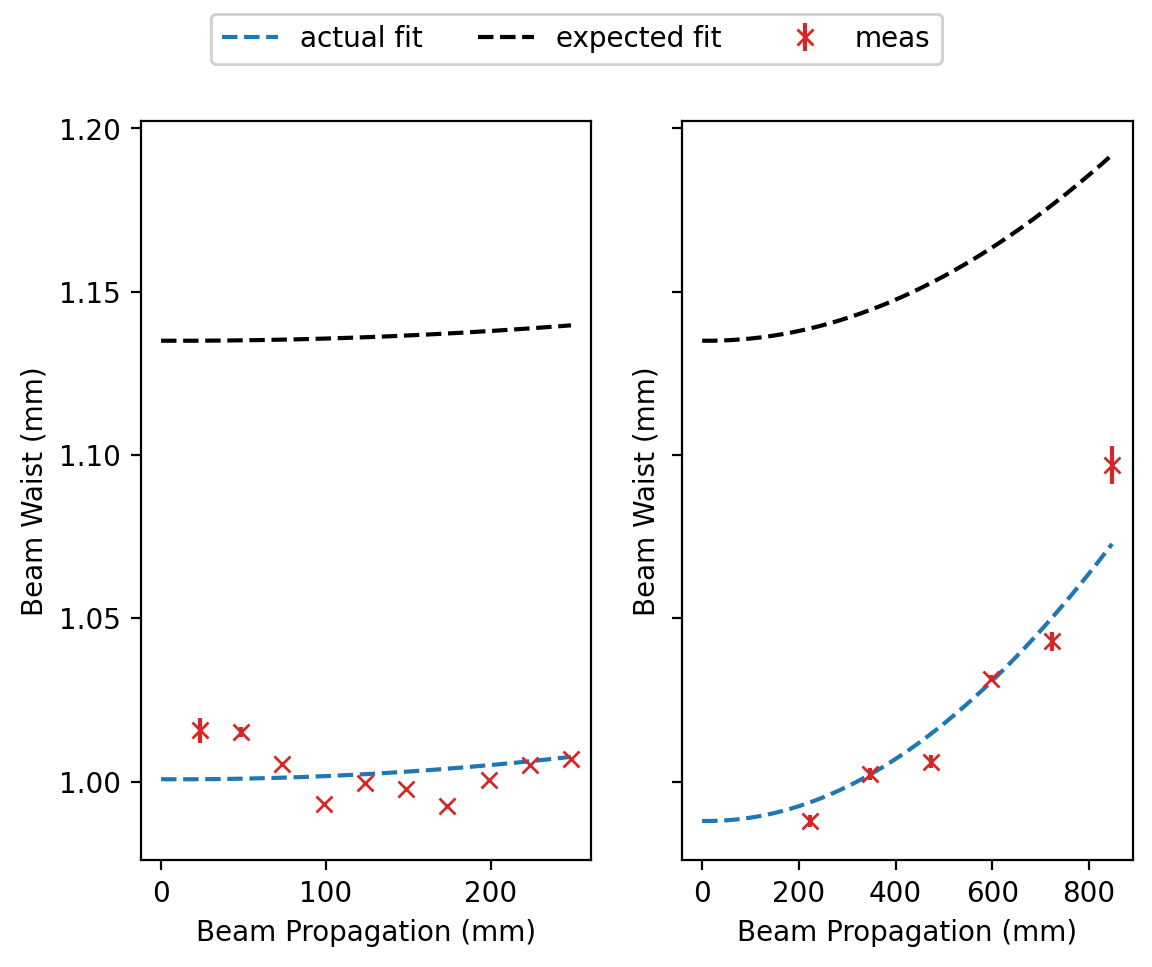

In [6]:
"""
The first point, p0, acted as the reference measurement for every other measurement's position.
Each new position was 5*25mm (5 holes) away from the last.
Razor blade is 0.68mm raised from the surface of the translation stage
When on the third hole, the translation stage is 24.23 - 0.68mm away from the collimator
"""
p0 = 97.5
ps = np.array([ (p*5*25) + p0 for p in range(1, n_positions+1) ]) * 1E-3


cp0 = (24.23 - 0.68)
cps = np.array([ (p*25) + cp0 for p in range(0,10)]) * 1E-3
from scipy.optimize import curve_fit


#all_ps = np.concatenate((ps,cps), axis=0)
#all_results = np.concatenate((results_1, results_2), axis=0)
def plot_beam_propagation(ax, results, ps):
    ws = np.array([ res[0] for res in results ]) * 1E-3 / 2
    ws_errs = np.array([ res[1] for res in results ]) * 1E-3 / 2

    coeffs, pcov = curve_fit(analyse.beam_radius, ps, ws)
    fit_ws = analyse.beam_radius(ps, *coeffs)

    fake_ps = np.linspace(0, max(ps), 1000)
    expected_ws = np.array(list(map(lambda p: analyse.beam_radius(p, (2.27E-3)/2, 20), fake_ps)))
    fit_ws = np.array(list(map(lambda p: analyse.beam_radius(p, *coeffs), fake_ps)))
    

    ax.plot(fake_ps*1E3, fit_ws*1E3, linestyle='--', c="tab:blue",label="actual fit")
    ax.plot(fake_ps*1E3, expected_ws*1E3, linestyle='--', c='k', label="expected fit")
    ax.errorbar(ps*1E3, ws*1E3, yerr=ws_errs*1E3, linestyle='', marker='x', color="tab:red", label="meas")
    ax.set_xlabel("Beam Propagation (mm)")
    ax.set_ylabel("Beam Waist (mm)")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3)

fig, (ax1,ax2) = plt.subplots(1,2,dpi=200, sharey=True)
plot_beam_propagation(ax2, results_1, ps)
plot_beam_propagation(ax1, results_2, cps)
